In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2022-08-01 12:23:01.055425: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 18182704713172282170
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 6083313664
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16642853353142618701
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:2b:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

2022-08-01 12:23:01.091509: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-01 12:23:01.119839: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-01 12:23:01.119992: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-01 12:23:01.464636: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-01 12:23:01.464773: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

In [2]:
import h5py
# load dataset
h5 = h5py.File('./data/NG_07152022.hdf5', mode='r')
dataset = h5.get('phi')

# shuffle dataset
data_sz = dataset.shape[0]
print(f"Selected number of cases: {data_sz}")
indexes = np.arange(data_sz)
np.random.shuffle(indexes)
train_index = np.sort(indexes[: int(0.75 * data_sz)])
val_index = np.sort(indexes[int(0.75 * data_sz) :])

# check dataset size
print(f'Dataset shape is: {dataset.shape}')
train_dataset = np.take(dataset,train_index,axis=0)
print(f'Splitted trainning dataset shape is: {train_dataset.shape}')
val_dataset = np.take(dataset,val_index,axis=0)
print(f'Splitted trainning dataset shape is: {val_dataset.shape}')

Selected number of cases: 91
Dataset shape is: (91, 69, 100, 100, 5)
Splitted trainning dataset shape is: (68, 69, 100, 100, 5)
Splitted trainning dataset shape is: (23, 69, 100, 100, 5)


In [3]:
# from tqdm import tqdm

# def create_shifted_frames_many2one(dataset,numFrames):
#     sz = dataset.shape[0]*(dataset.shape[1]-numFrames)
#     x = np.zeros([sz, numFrames, dataset.shape[2],dataset.shape[3], 5])
#     y = np.zeros([sz, 2, dataset.shape[2],dataset.shape[3], 5])
#     k = 0
#     for i in tqdm(range(dataset.shape[0]), desc="Running ..."):
#         for j in range(dataset.shape[1]-numFrames):
#             currentFrame = np.expand_dims(np.expand_dims(dataset[i,j+numFrames,...],axis=0),axis=0)
#             pastFrames = np.expand_dims(dataset[i,j:(j+numFrames),...],axis=0)
#             x[k,...] = pastFrames
#             y[k,0,...] = currentFrame
#             y[k,1,...] = pastFrames[:,-1,...] # passing past frame to ground truth for use in loss function (an issue with directly passing inp into loss func)
#             k+=1  
#     return x,y

# def create_shifted_frames_many2one_append(dataset,numFrames):
#     for i in tqdm(range(dataset.shape[0]), desc="Running ..."):
#         for j in range(dataset.shape[1]-numFrames):
#             currentFrame = np.expand_dims(np.expand_dims(dataset[i,j+numFrames,...],axis=0),axis=0)
#             pastFrames = np.expand_dims(dataset[i,j:(j+numFrames),...],axis=0)
#             if np.amax(currentFrame[...,1])<1 or np.amax(pastFrames[:,0,:,:,1])<1 \
#                 or np.amax(pastFrames[:,1,:,:,1])<1 or np.amax(pastFrames[:,2,:,:,1])<1 \
#                     or np.amax(pastFrames[:,3,:,:,1])<1 or np.amax(pastFrames[:,4,:,:,1])<1:
#             # if np.amax(currentFrame[...,1])<1:
#                 pass
#             else:
#                 try:
#                     x = np.append(x,pastFrames,axis=0)
#                     y = np.append(y,currentFrame,axis=0)
#                     y1 = np.append(y1,pastFrames[:,-1,...],axis=0)
#                 except:
#                     x = pastFrames
#                     y = currentFrame
#                     y1 = pastFrames[:,-1,...]
#     y = np.concatenate((y,np.expand_dims(y1,axis=1)),axis=1)
#     return x,y

# # creatign many to 1 shifted trainning and validation dataset
# numFrames = 5
# x_train, y_train = create_shifted_frames_many2one_append(train_dataset,numFrames)
# x_val, y_val = create_shifted_frames_many2one_append(val_dataset,numFrames)

# # increase tubulin magnitude (actual value too small)
# x_train[...,2] = x_train[...,2]
# y_train[...,2] = y_train[...,2]
# x_val[...,2] = x_val[...,2]
# y_val[...,2] = y_val[...,2]

# print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
# print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

# # some wierd memory issue with tensorflow, same batch size with smaller dataset size works
# x_train = np.take(x_train,np.arange(3000),axis=0)
# y_train = np.take(y_train,np.arange(3000),axis=0)
# x_val = np.take(x_val,np.arange(1000),axis=0)
# y_val = np.take(y_val,np.arange(1000),axis=0)

# print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
# print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

In [4]:
x_train = np.load("x_train.npy")
y_train = np.load("y_train.npy")
# y_train = y_train[:,0,...]
# y_train = np.expand_dims(y_train,axis=1)
x_val = np.load("x_val.npy")
y_val = np.load("y_val.npy")
# y_val = y_val[:,0,...]
# y_val = np.expand_dims(y_val,axis=1)

numFrames = x_train.shape[1]
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

Training Dataset Shapes: (3000, 5, 100, 100, 5), (3000, 2, 100, 100, 5)
Validation Dataset Shapes: (1000, 5, 100, 100, 5), (1000, 2, 100, 100, 5)


(3000, 5, 100, 100, 5)
1095


Text(0.5, 1.0, 'Goal Frame 5')

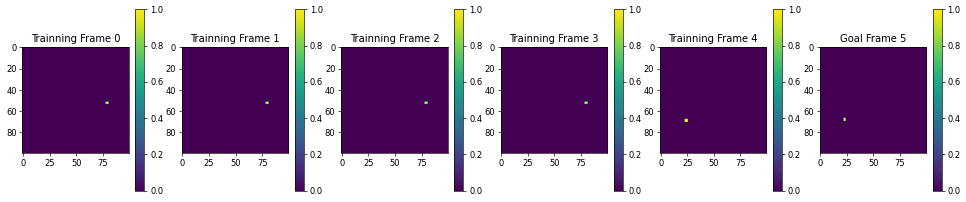

In [5]:
print(x_train.shape)
data_choice = np.random.choice(range(len(x_train)), size=1)[0]
print(data_choice)
channel = 1
plt.figure(figsize=(20, 4), dpi=60)
for i in range(numFrames):
    plt.subplot(1,numFrames+1,i+1)
    plt.imshow(x_train[data_choice,i,:,:,channel])
    plt.colorbar()
    plt.title(f"Trainning Frame {i}")

plt.subplot(1,numFrames+1,numFrames+1)
plt.imshow(y_train[data_choice,0,:,:,channel])
plt.colorbar()
plt.title(f"Goal Frame {numFrames}")

In [6]:
# def sum_filter_python(phi):
#     phi = phi.numpy()
#     Nx = phi.shape[0]
#     Ny = phi.shape[1]
#     phi = np.round(phi)

#     phi_sum = np.zeros([Nx,Ny])
#     for i in range(5,Nx-4):
#         for k in range(5,Ny-4):
#             for j in range(k-4,k+4+1):
#                 phi_sum[i,k] = phi_sum[i,k] + int(phi[i,k]==phi[i-4,j])*phi[i-4,j] + int(phi[i,k]==phi[i-3,j])*phi[i-3,j] + int(phi[i,k]==phi[i-2,j])*phi[i-2,j] + int(phi[i,k]==phi[i-1,j])*phi[i-1,j] + int(phi[i,k]==phi[i-0,j])*phi[i,j] + int(phi[i,k]==phi[i+1,j])*phi[i+1,j] + int(phi[i,k]==phi[i+2,j])*phi[i+2,j] + int(phi[i,k]==phi[i+3,j])*phi[i+3,j] + int(phi[i,k]==phi[i+4,j])*phi[i+4,j]

#     phi_sum = np.divide(phi,phi_sum)
#     phi_sum[np.isnan(phi_sum)] = 0
#     phi_sum_max = np.amax(np.amax(phi_sum))
#     phi_sum = np.divide(phi_sum,phi_sum_max)

#     phi_sum_temp = phi_sum
#     cutoff = np.percentile(np.reshape(phi_sum_temp,[Nx*Ny,1]),99.97)
#     phi_sum[phi_sum<cutoff] = 0
#     phi_sum[phi_sum!=1] = 0  
#     return phi_sum

# def highlightZone(tip):
#     [Max_y,Max_x] = np.where(tip==1)
#     size_Max = len(Max_x)
#     Nx, Ny = tip.shape
#     tips = np.zeros([Nx,Ny])
#     temp = np.zeros([Nx,Ny])
#     for l in range(0,size_Max):
#         max_x = Max_x[l]
#         max_y = Max_y[l]
#         for i in range(max_y-2,max_y+2):
#             for j in range(max_x-2,max_x+2):
#                     temp[i,j] = 1
#         tips = tips+temp

#     tips[np.abs(tips)>0] = 1
#     return tips

In [7]:
# phi = train_dataset[50,24,:,:,0]
# tips = train_dataset[50,24,:,:,1]
# # tips_test = sum_filter_python(phi)
# [Nx,Ny] = np.shape(phi)
# phi = np.round(phi)
# phi_sum = np.zeros([Nx,Ny])
# for i in range(5,Nx-4):
#     for k in range(5,Ny-4):
#         for j in range(k-4,k+4+1):
#             phi_sum[i,k] = phi_sum[i,k] + int(phi[i,k]==phi[i-4,j])*phi[i-4,j] + int(phi[i,k]==phi[i-3,j])*phi[i-3,j] + int(phi[i,k]==phi[i-2,j])*phi[i-2,j] + int(phi[i,k]==phi[i-1,j])*phi[i-1,j] + int(phi[i,k]==phi[i-0,j])*phi[i,j] + int(phi[i,k]==phi[i+1,j])*phi[i+1,j] + int(phi[i,k]==phi[i+2,j])*phi[i+2,j] + int(phi[i,k]==phi[i+3,j])*phi[i+3,j] + int(phi[i,k]==phi[i+4,j])*phi[i+4,j]
# phi_sum = np.divide(phi,phi_sum)
# phi_sum[np.isnan(phi_sum)] = 0
# phi_sum_max = np.amax(np.amax(phi_sum))
# phi_sum = np.divide(phi_sum,phi_sum_max)

# phi_sum_temp = phi_sum
# cutoff = np.percentile(np.reshape(phi_sum_temp,[Nx*Ny,1]),99.97)
# phi_sum[phi_sum<cutoff] = 0
# phi_sum[phi_sum!=1] = 0  

# tips_test = highlightZone(phi_sum)

# plt.subplot(1,3,1)
# plt.imshow(phi)
# plt.colorbar()
# plt.subplot(1,3,2)
# plt.imshow(tips)
# plt.colorbar()
# plt.subplot(1,3,3)
# plt.imshow(tips_test)
# plt.colorbar()

In [8]:
# function to calculate partial derivatives of the input
def get_deriv(input):
    N1N_input, NN1_input = tf.image.image_gradients(input)
    N2N_input, _ = tf.image.image_gradients(N1N_input)
    _, NN2_input = tf.image.image_gradients(NN1_input)
    LAP_input = tf.math.add(N2N_input,NN2_input)
    return N1N_input, NN1_input, N2N_input, NN2_input, LAP_input

# calculate MSE
def get_MSE_tf(input,goal):
    return tf.math.reduce_mean(tf.square(tf.math.subtract(input, goal)))

def get_MAE_tf(input,goal):
    return tf.math.sqrt(tf.math.reduce_mean(tf.math.square(input-goal)))

def get_MRE_tf(input,goal):
    return tf.math.divide(get_MAE_tf(input,goal),(tf.math.reduce_max(goal)-tf.math.reduce_min(goal)))
    
# PINN - physics-informed loss function for Phase-field neuron growth model
def PINN_loss():
    def loss(y_true, y_pred):
        dt = 0.01*10 # current data sampled per 500 iter (change based on dataset)
        # y_true = tf.cast(y_true, dtype=tf.float64)
        # y_pred = tf.cast(y_pred, dtype=tf.float64)

        # # extract variables from ground truth
        true_phi = tf.expand_dims(y_true[:,0,:,:,0],axis=3)
        true_tips = tf.expand_dims(y_true[:,0,:,:,1],axis=3)
        true_tub = tf.expand_dims(y_true[:,0,:,:,2],axis=3)
        true_tempr = tf.expand_dims(y_true[:,0,:,:,3],axis=3)
        theta = tf.expand_dims(y_true[:,0,:,:,4],axis=3) # Since theta is passed, theta remains the same
        # # extract variables from previous iteration (intentionally placed in ground truth so it is easier to access)
        # NN_p = tf.expand_dims(inp[:,-1,:,:,0],axis=3)
        # tips_p = tf.expand_dims(inp[:,-1,:,:,1],axis=3)
        # tub_p = tf.expand_dims(inp[:,-1,:,:,2],axis=3)
        # tempr_p = tf.expand_dims(inp[:,-1,:,:,3],axis=3)
        # extract variables from previous iteration (intentionally placed in ground truth so it is easier to access)
        NN_p = tf.expand_dims(y_true[:,1,:,:,0],axis=3)
        tips_p = tf.expand_dims(y_true[:,1,:,:,1],axis=3)
        tub_p = tf.expand_dims(y_true[:,1,:,:,2],axis=3)
        tempr_p = tf.expand_dims(y_true[:,1,:,:,3],axis=3)
        # extract variables from prediction
        NN_pK = tf.expand_dims(y_pred[:,-1,:,:,0],axis=3)
        tips_pK = tf.expand_dims(y_pred[:,-1,:,:,1],axis=3)
        tub_pK = tf.expand_dims(y_pred[:,-1,:,:,2],axis=3)
        tempr_pK = tf.expand_dims(y_pred[:,-1,:,:,3],axis=3)

        # calc corresponding partial derivatives
        N1N_p, NN1_p, _, _, LAP_p = get_deriv(NN_p)
        N1N_theta, NN1_theta, _, _, _ = get_deriv(theta)
        _, _, _, _, LAP_tp = get_deriv(tempr_p)
        N1N_tb, NN1_tb, _, _, LAP_tb = get_deriv(tub_p)

        # Temperature residual
        tempr_residual = (3*LAP_tp+4*(NN_pK - NN_p)/dt)*dt + tempr_p - tempr_pK

        # Tubulin residual
        diff_tb = 4*(tf.math.multiply(N1N_p,N1N_tb) + tf.math.multiply(NN1_p,NN1_tb) + tf.math.multiply(NN_p,LAP_tb))
        alph_tb = 0.001*(tf.math.multiply(N1N_p,tub_p) + tf.math.multiply(NN_p,N1N_tb) + tf.math.multiply(NN1_p,tub_p) + tf.math.multiply(NN_p,NN1_tb))
        beta_tb = 0.001*tf.math.multiply(NN_p,tub_p)
        src_tb = tf.math.divide_no_nan(15*tf.math.square(LAP_p),tf.math.reduce_sum(tf.math.square(LAP_p)))
        tub_residual = (diff_tb - alph_tb - beta_tb + src_tb)*dt + tub_p - tub_pK

        # phase field residual
        e = 0.2865*tf.math.atan(10*tf.math.multiply(tf.math.multiply(tips_p,5*tub_pK-0.1),1-tempr_pK)) # energy equation
        atheta = tf.math.atan2(NN1_p,N1N_p)
        a = 0.04*(1.0+0.1*tf.math.cos(6*(atheta-theta)))
        ap = -0.04*(6*0.1*tf.math.sin(6*(atheta-theta)))
        aap = tf.math.multiply(a,ap)
        a2 = tf.math.square(a)
        a2Lap = tf.math.multiply(a2,LAP_p)
        N1N_aapNN1p, _ = tf.image.image_gradients(tf.math.multiply(aap,NN1_p))
        _, NN1_aapN1Np = tf.image.image_gradients(tf.math.multiply(aap,N1N_p))
        mag_theta = tf.math.sqrt(tf.math.square(N1N_theta) + tf.math.square(NN1_theta))
        dblwll_term = tf.math.multiply(tf.math.multiply(NN_p,1-NN_p),NN_p - 0.5 + e + 6*0.007*mag_theta)
        phi_residual = a2Lap - N1N_aapNN1p + NN1_aapN1Np + dblwll_term - (NN_pK - NN_p) / dt

        # calculate mean of each residual and mse of prediction and ground truth
        residual_mse = tf.math.reduce_mean(phi_residual) + tf.math.reduce_mean(tempr_residual) + tf.math.reduce_mean(tub_residual)
        bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

        # diff_mse = get_MSE_tf(NN_pK,true_phi) + get_MSE_tf(tips_pK,true_tips) + get_MSE_tf(tempr_pK,true_tempr) + get_MRE_tf(tub_pK,true_tub)
        # diff_mse = get_MSE_tf(NN_pK,true_phi) + bce(tips_pK,true_tips) + get_MSE_tf(tempr_pK,true_tempr) + get_MRE_tf(tub_pK,true_tub)
        diff_mse = get_MSE_tf(NN_pK,true_phi) + get_MRE_tf(tempr_pK,true_tempr) + get_MRE_tf(tub_pK,true_tub)
        
        return tf.math.abs(residual_mse) + tf.math.abs(diff_mse)
        # return tf.math.reduce_max(inp)
    return loss

In [9]:
# from tensorflow.keras import layers
# inp = layers.Input(shape=(x_train.shape[1:]))

# @tf.function
# def tdConv(inp, numfilters):
# # Separable Convolution Encoding
#     x0 = layers.TimeDistributed(layers.Conv2D(
#         filters=64,
#         kernel_size=(5, 5),
#         strides = (2, 2),
#         padding="valid",
#         activation="relu",
#     ))(inp)
#     x1 = layers.TimeDistributed(layers.Conv2D(
#         filters=128,
#         kernel_size=(5, 5),
#         strides = (2, 2),
#         padding="valid",
#         activation="relu",
#     ))(x0)
#     # recurrent cell, 5 time step to 1 time step
#     x2 = layers.ConvLSTM2D(
#         filters=128,
#         kernel_size=(5, 5),
#         padding="same",
#         return_sequences=False,
#         activation="relu",
#         # recurrent_dropout=drop_rate,
#     )(x1)
#     return x2

# @tf.function
# def PhiDecode(x2):
#     phi1 = x2
#     phi2 = layers.Conv2DTranspose(
#         filters=64,
#         kernel_size=(6, 6),
#         strides = (2, 2),
#         padding="valid",
#         activation="sigmoid",
#     )(phi1)
#     phi3 = layers.Conv2DTranspose(
#         filters=1,
#         kernel_size=(6, 6),
#         strides = (2, 2),
#         padding="valid",
#         activation="sigmoid",
#     )(phi2)
#     return phi3

# @tf.function
# def TipDecode(phi3):
#     tip1 = layers.Conv2D(
#         filters=64,
#         kernel_size=(5, 5),
#         strides = (1, 1),
#         padding="same",
#         activation="relu",
#         use_bias=True,
#     )(phi3)
#     tip2 = layers.Conv2DTranspose(
#         filters=1,
#         kernel_size=(5, 5),
#         strides = (1, 1),
#         padding="same",
#         activation="sigmoid",
#     )(tip1)
#     return tip2

# @tf.function
# def tubDecode(x2):
#     tub1 = x2
#     tub2 = layers.Conv2DTranspose(
#         filters=64,
#         kernel_size=(6, 6),
#         strides = (2, 2),
#         padding="valid",
#         activation="relu",
#         use_bias=True,
#     )(tub1)
#     tub3 = layers.Conv2DTranspose(
#         filters=1,
#         kernel_size=(6, 6),
#         strides = (2, 2),
#         padding="valid",
#         activation="relu",
#         use_bias=True,
#     )(tub2)
#     tub4 = tf.math.multiply(phi3,tub3)
#     return tub4

# @tf.function
# def temprDecode(x2,inp,phi3):
#     tempr1 = x2
#     tempr2 = tf.keras.layers.Conv2DTranspose(
#         filters=64,
#         kernel_size=(6, 6),
#         strides = (2, 2),
#         padding="valid",
#         activation="relu",
#         use_bias=True,
#     )(tempr1)
#     tempr3 = tf.keras.layers.Conv2DTranspose(
#         filters=1,
#         kernel_size=(6, 6),
#         strides = (2, 2),
#         padding="valid",
#         activation="relu",
#         use_bias=True,
#     )(tempr2)
#     phi_pre = tf.expand_dims(inp[:,-1,:,:,0],axis=3)
#     tempr3 = tf.concat([tempr3, phi3-phi_pre],axis=3)
#     tempr4 = tf.keras.layers.Conv2D(
#         filters=1,
#         kernel_size=(6, 6),
#         strides = (1, 1),
#         padding="same",
#         activation="relu",
#         use_bias=True,
#     )(tempr3)
#     return tempr4

# @tf.function
# def passTheta(inp):
#     return tf.expand_dims(inp[:,0,:,:,-1],axis=3)

# @tf.function
# def outConcat(phi3,tip2,tub4,tempr4,theta1):
#     return tf.expand_dims(tf.concat([phi3,tip2,tub4,tempr4,theta1],axis=3),axis=1)

# # Convolution Encoding
# x2 = tdConv(inp)

# # decoding for phi channel
# phi3 = PhiDecode(x2)

# # decoding for tips channel
# tip2 = TipDecode(phi3)

# # decoding for tublin channel
# tub4 = tubDecode(x2)

# # decoding for temperature channel
# tempr4 = temprDecode(x2,inp,phi3)

# # passing theta (no change)
# theta1 = passTheta(inp)

# # concat all to generate output
# out = outConcat(phi3,tip2,tub4,tempr4,theta1)

In [10]:
from tensorflow.keras import layers
inp = layers.Input(shape=(x_train.shape[1:]))

# Separable Convolution Encoding
x0 = layers.TimeDistributed(layers.Conv2D(
    filters=64,
    kernel_size=(5, 5),
    strides = (2, 2),
    padding="valid",
    activation="relu",
))(inp)
x1 = layers.TimeDistributed(layers.Conv2D(
    filters=128,
    kernel_size=(5, 5),
    strides = (2, 2),
    padding="valid",
    activation="relu",
))(x0)
# recurrent cell, 5 time step to 1 time step
x2 = layers.ConvLSTM2D(
    filters=128,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=False,
    activation="relu",
    # recurrent_dropout=drop_rate,
)(x1)
# x2 = tf.expand_dims(x2,axis=1)

# decoding for phi channel
phi1 = x2
phi2 = layers.Conv2DTranspose(
    filters=64,
    kernel_size=(6, 6),
    strides = (2, 2),
    padding="valid",
    activation="relu",
)(phi1)
phi3 = layers.Conv2DTranspose(
    filters=1,
    kernel_size=(6, 6),
    strides = (2, 2),
    padding="valid",
    activation="sigmoid",
)(phi2)

# decoding for tips channel
# tip1 = layers.Conv2D(
#     filters=64,
#     kernel_size=(5, 5),
#     strides = (1, 1),
#     padding="same",
#     activation="relu",
#     use_bias=True,
# )(phi3)
# tip2 = layers.Conv2DTranspose(
#     filters=1,
#     kernel_size=(5, 5),
#     strides = (1, 1),
#     padding="same",
#     activation="sigmoid",
# )(tip1)

# decoding for tublin channel
tub1 = x2
tub2 = layers.Conv2DTranspose(
    filters=64,
    kernel_size=(6, 6),
    strides = (2, 2),
    padding="valid",
    activation="relu",
    use_bias=True,
)(tub1)
tub3 = layers.Conv2DTranspose(
    filters=1,
    kernel_size=(6, 6),
    strides = (2, 2),
    padding="valid",
    activation="relu",
    use_bias=True,
)(tub2)
tub4 = tf.math.multiply(phi3,tub3)

# decoding for temperature channel
tempr1 = x2
tempr2 = tf.keras.layers.Conv2DTranspose(
    filters=64,
    kernel_size=(6, 6),
    strides = (2, 2),
    padding="valid",
    activation="relu",
    use_bias=True,
)(tempr1)
tempr3 = tf.keras.layers.Conv2DTranspose(
    filters=1,
    kernel_size=(6, 6),
    strides = (2, 2),
    padding="valid",
    activation="relu",
    use_bias=True,
)(tempr2)
phi_pre = tf.expand_dims(inp[:,-1,:,:,0],axis=3)
tempr3 = tf.concat([tempr3, phi3-phi_pre],axis=3)
tempr4 = tf.keras.layers.Conv2D(
    filters=1,
    kernel_size=(6, 6),
    strides = (1, 1),
    padding="same",
    activation="relu",
    use_bias=True,
)(tempr3)

# passing theta (no change)
theta1 = tf.expand_dims(inp[:,0,:,:,-1],axis=3)
tip2 = tf.expand_dims(inp[:,0,:,:,1],axis=3)

# concat all to generate output
out = tf.expand_dims(tf.concat([phi3,tip2,tub4,tempr4,theta1],axis=3),axis=1)

2022-08-01 12:23:20.933064: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-01 12:23:20.933241: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-01 12:23:20.933348: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-01 12:23:20.933606: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-01 12:23:20.933718: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

In [11]:
# import sys
# sys.setrecursionlimit(10000)

# from tensorflow.python.framework.ops import disable_eager_execution
# disable_eager_execution()

# target = layers.Input(shape=(y_train.shape[1:]))
# print(target.shape)
# model = keras.models.Model([inp,target], out)
# model.add_loss(PINN_loss_1(target,out,inp))
model = keras.models.Model(inp, out)
model.compile(
    loss=PINN_loss(),
    # loss=None,
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    )
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5, 100, 100  0           []                               
                                , 5)]                                                             
                                                                                                  
 time_distributed (TimeDistribu  (None, 5, 48, 48, 6  8064       ['input_1[0][0]']                
 ted)                           4)                                                                
                                                                                                  
 time_distributed_1 (TimeDistri  (None, 5, 22, 22, 1  204928     ['time_distributed[0][0]']       
 buted)                         28)                                                           

In [12]:
test = False

if test == True:
    model = keras.models.load_model('./saved_model/model_conv_lstm_test_32', custom_objects={'loss': PINN_loss()})
else: 
    early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=15)
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='TB_logDir', histogram_freq=1)
    with tf.device('/device:GPU:0'):
        model.fit(
            x_train,
            y_train,
            batch_size=5,
            epochs=1000,
            validation_data=(x_val, y_val),
            callbacks=[early_stopping, reduce_lr, tensorboard_callback],
        )
    model.save('./saved_model/model_conv_lstm_test_32') 

2022-08-01 12:23:21.934738: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3000000000 exceeds 10% of free system memory.
2022-08-01 12:23:23.690171: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3000000000 exceeds 10% of free system memory.


Epoch 1/1000


2022-08-01 12:23:26.762148: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] layout failed: INVALID_ARGUMENT: MutableGraphView::SortTopologically error: detected edge(s) creating cycle(s) {'Func/gradient_tape/model/conv_lstm2d/while/model/conv_lstm2d/while_grad/body/_189/input/_551' -> 'gradient_tape/model/conv_lstm2d/while/model/conv_lstm2d/while_grad/body/_189/gradient_tape/model/conv_lstm2d/while/gradients/AddN', 'model/conv_lstm2d/while/body/_1/model/conv_lstm2d/while/mul_2' -> 'model/conv_lstm2d/while/body/_1/model/conv_lstm2d/while/add_5', 'model/conv_lstm2d/while/body/_1/model/conv_lstm2d/while/clip_by_value_2' -> 'model/conv_lstm2d/while/body/_1/model/conv_lstm2d/while/mul_5', 'model/conv_lstm2d/while/body/_1/model/conv_lstm2d/while/clip_by_value' -> 'model/conv_lstm2d/while/body/_1/model/conv_lstm2d/while/mul_3', 'model/conv_lstm2d/while/body/_1/model/conv_lstm2d/while/convolution_6' -> 'model/conv_lstm2d/while/body/_1/model/conv_lstm2d/while/add_4'}.
2022-08-01 12

599/600 [============================>.] - ETA: 0s - loss: 0.4826

2022-08-01 12:23:51.661113: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] layout failed: INVALID_ARGUMENT: MutableGraphView::SortTopologically error: detected edge(s) creating cycle(s) {'model/conv_lstm2d/while/body/_1/model/conv_lstm2d/while/Relu_1' -> 'model/conv_lstm2d/while/body/_1/model/conv_lstm2d/while/mul_5', 'model/conv_lstm2d/while/body/_1/model/conv_lstm2d/while/mul_2' -> 'model/conv_lstm2d/while/body/_1/model/conv_lstm2d/while/add_5', 'model/conv_lstm2d/while/body/_1/model/conv_lstm2d/while/convolution_7' -> 'model/conv_lstm2d/while/body/_1/model/conv_lstm2d/while/add_6'}.


600/600 [==============================] - 30s 43ms/step - loss: 0.4825 - val_loss: 0.5224 - lr: 1.0000e-04
Epoch 2/1000
600/600 [==============================] - 24s 41ms/step - loss: 0.3509 - val_loss: 0.3746 - lr: 1.0000e-04
Epoch 3/1000
600/600 [==============================] - 25s 41ms/step - loss: 0.2542 - val_loss: 0.2563 - lr: 1.0000e-04
Epoch 4/1000
600/600 [==============================] - 24s 41ms/step - loss: 0.1842 - val_loss: 0.2344 - lr: 1.0000e-04
Epoch 5/1000
600/600 [==============================] - 25s 41ms/step - loss: 0.1667 - val_loss: 0.1893 - lr: 1.0000e-04
Epoch 6/1000
600/600 [==============================] - 25s 41ms/step - loss: 0.1573 - val_loss: 0.1981 - lr: 1.0000e-04
Epoch 7/1000
600/600 [==============================] - 25s 41ms/step - loss: 0.1505 - val_loss: 0.1808 - lr: 1.0000e-04
Epoch 8/1000
600/600 [==============================] - 25s 41ms/step - loss: 0.1460 - val_loss: 0.1691 - lr: 1.0000e-04
Epoch 9/1000
600/600 [=======================

INFO:tensorflow:Assets written to: ./saved_model/model_conv_lstm_test_32/assets


INFO:tensorflow:Assets written to: ./saved_model/model_conv_lstm_test_32/assets


Random case: 12


Plotting and Saving figures ...:  31%|███▏      | 20/64 [00:09<00:13,  3.23it/s]/tmp/ipykernel_194868/695343827.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(25, 12), dpi=60)
Plotting and Saving figures ...: 100%|██████████| 64/64 [00:34<00:00,  1.83it/s]


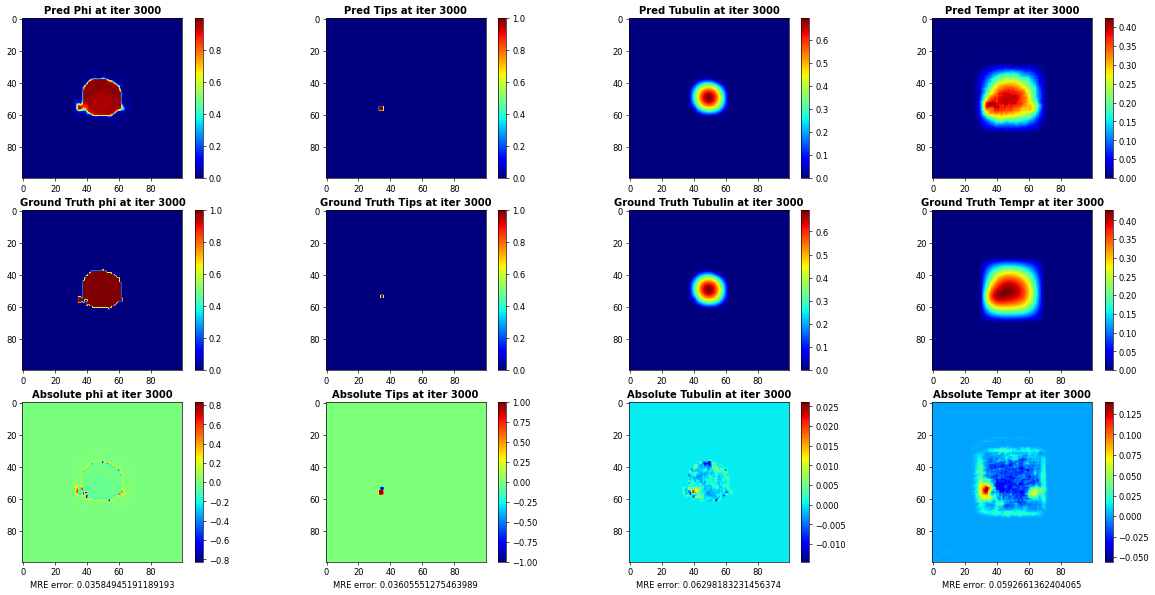

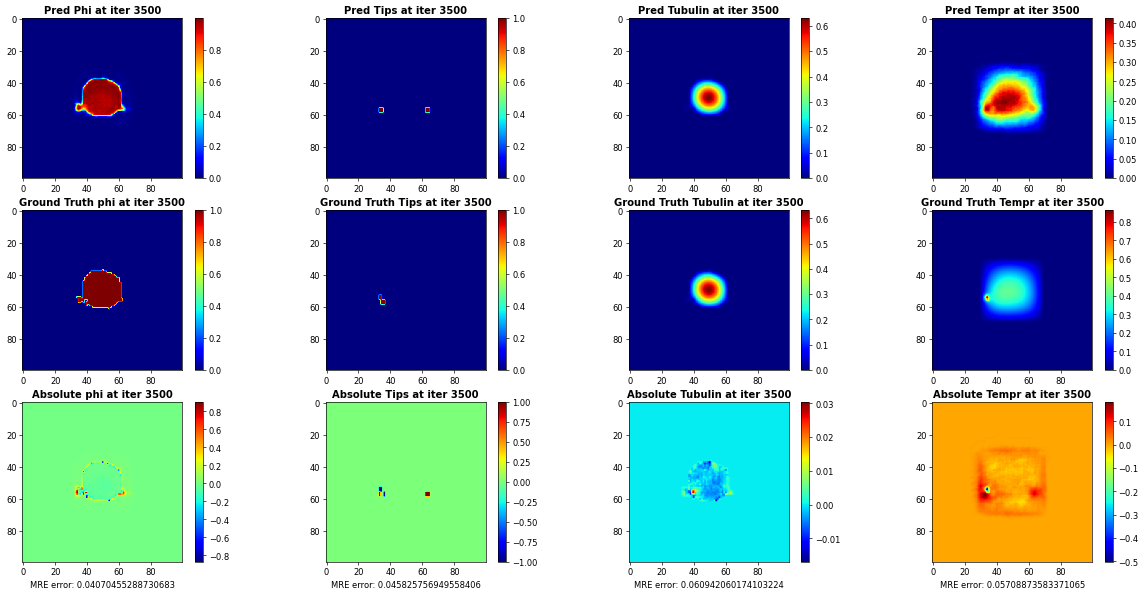

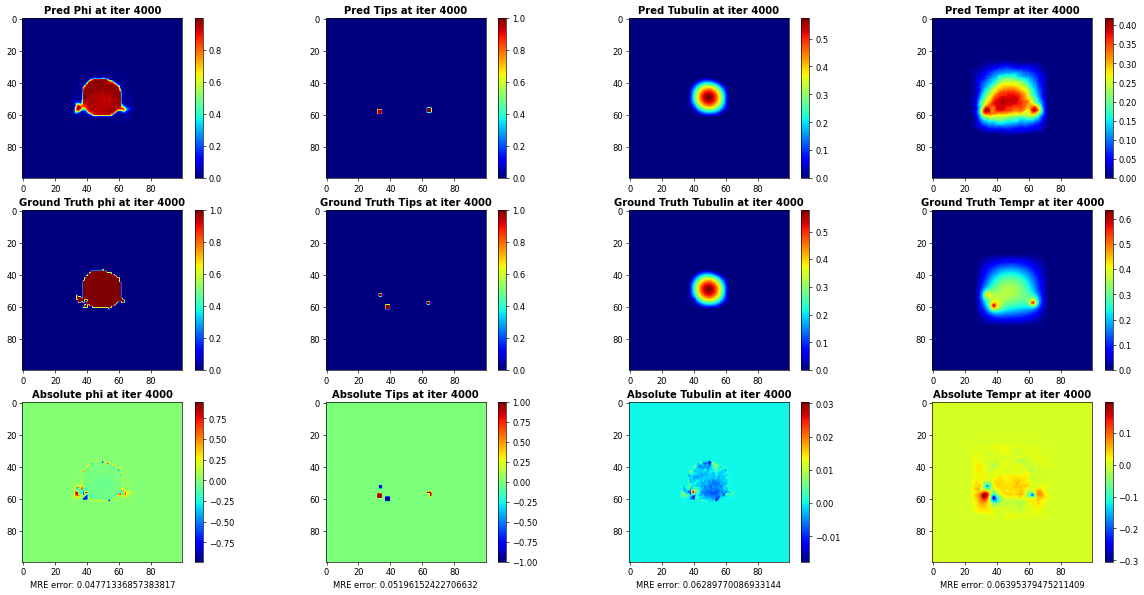

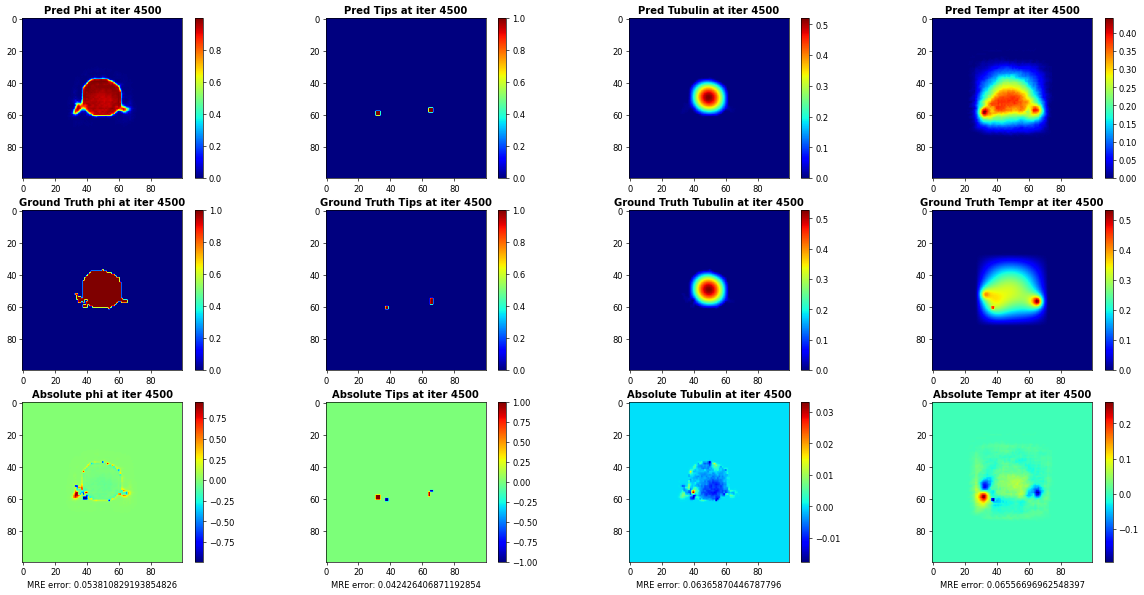

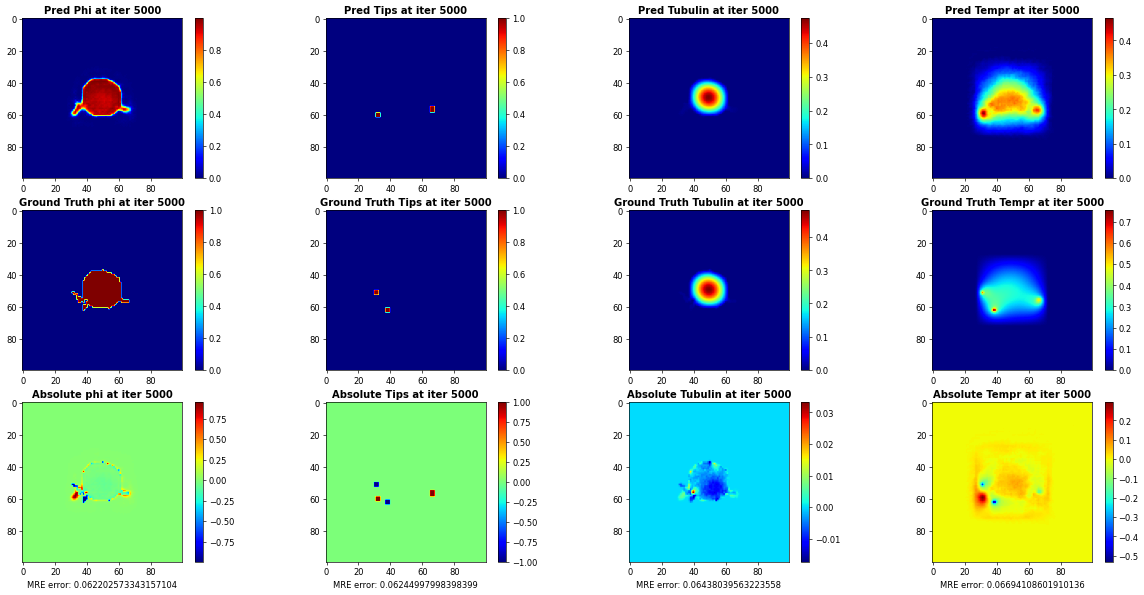

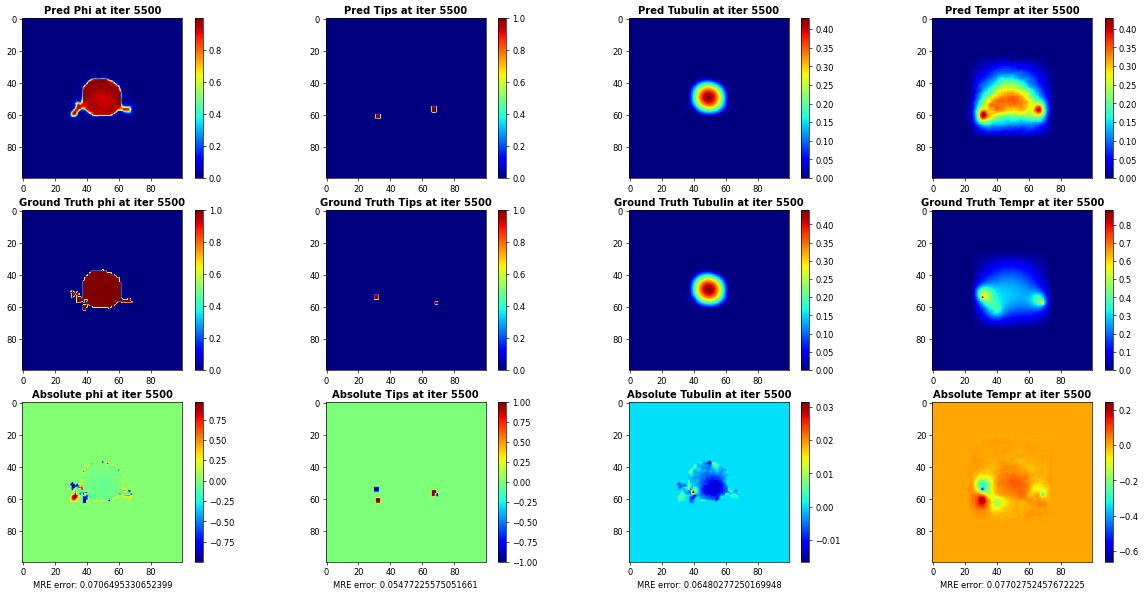

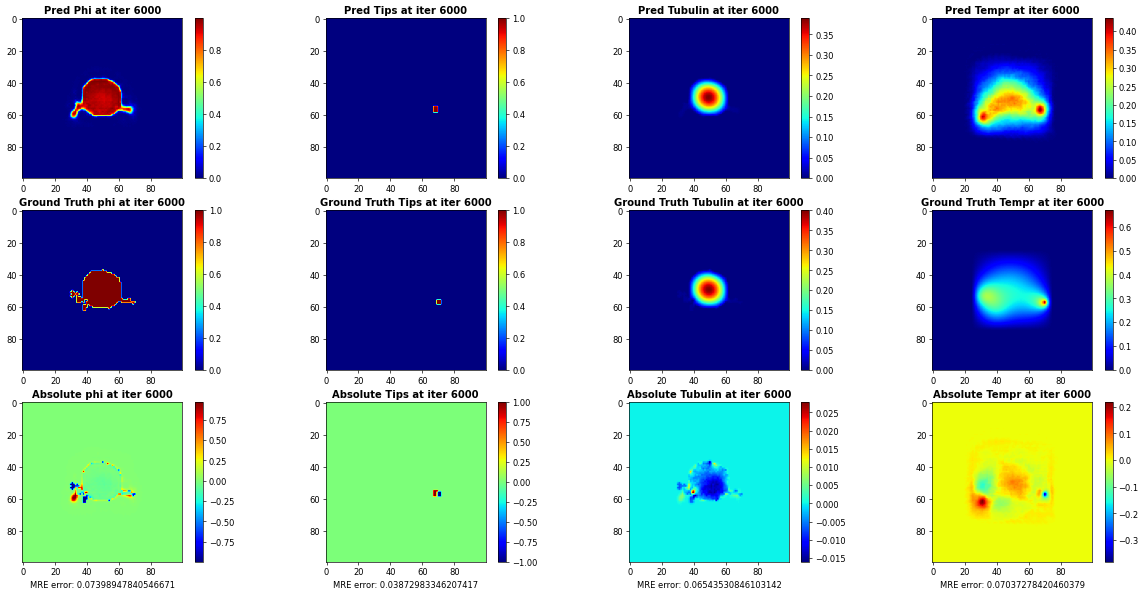

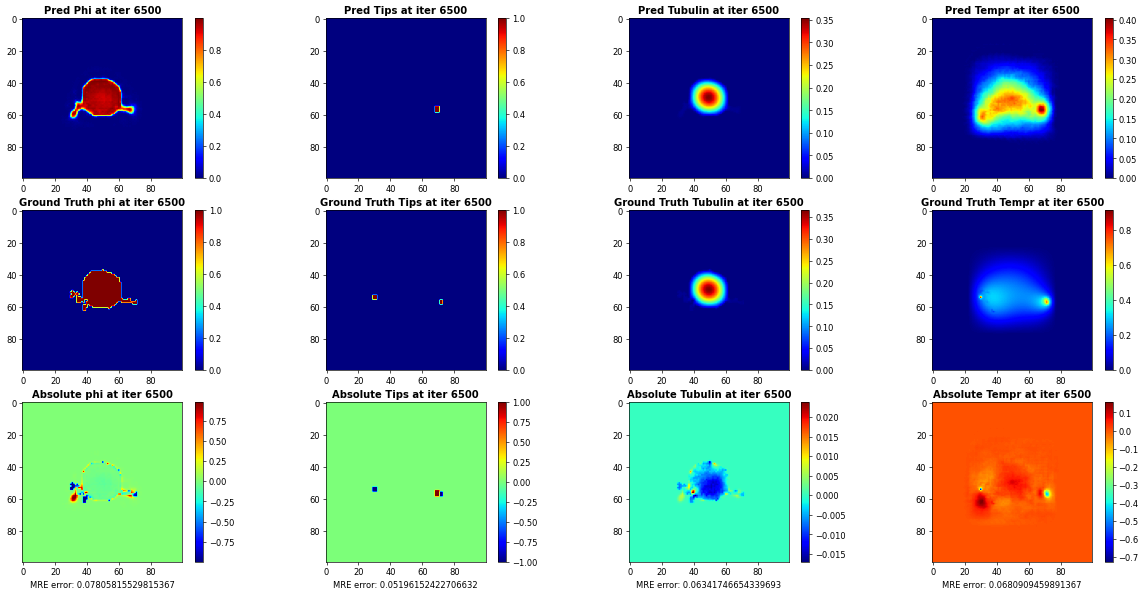

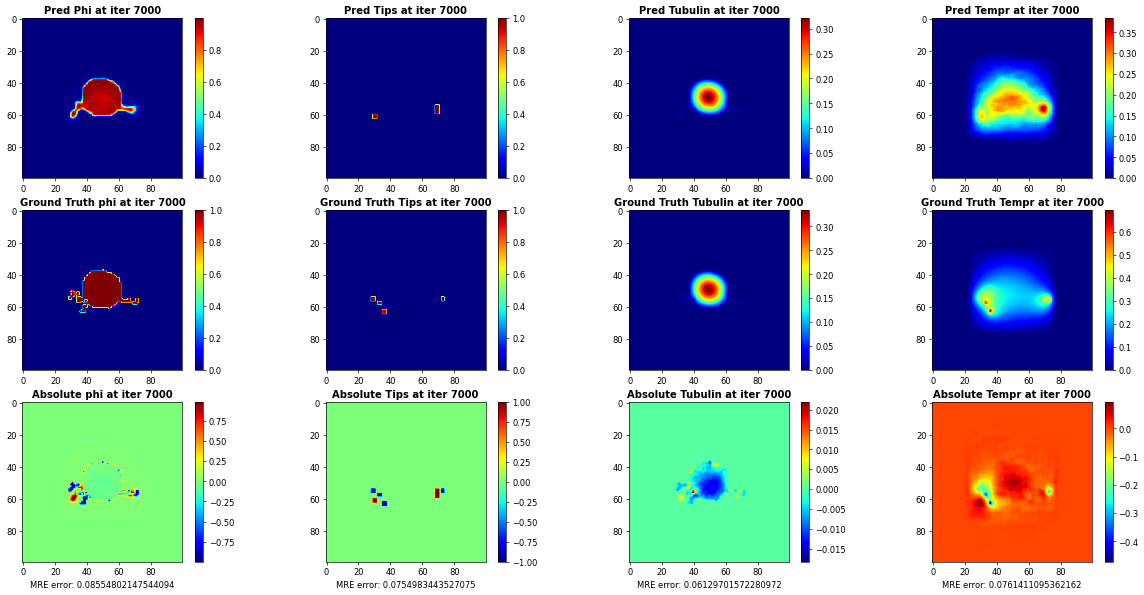

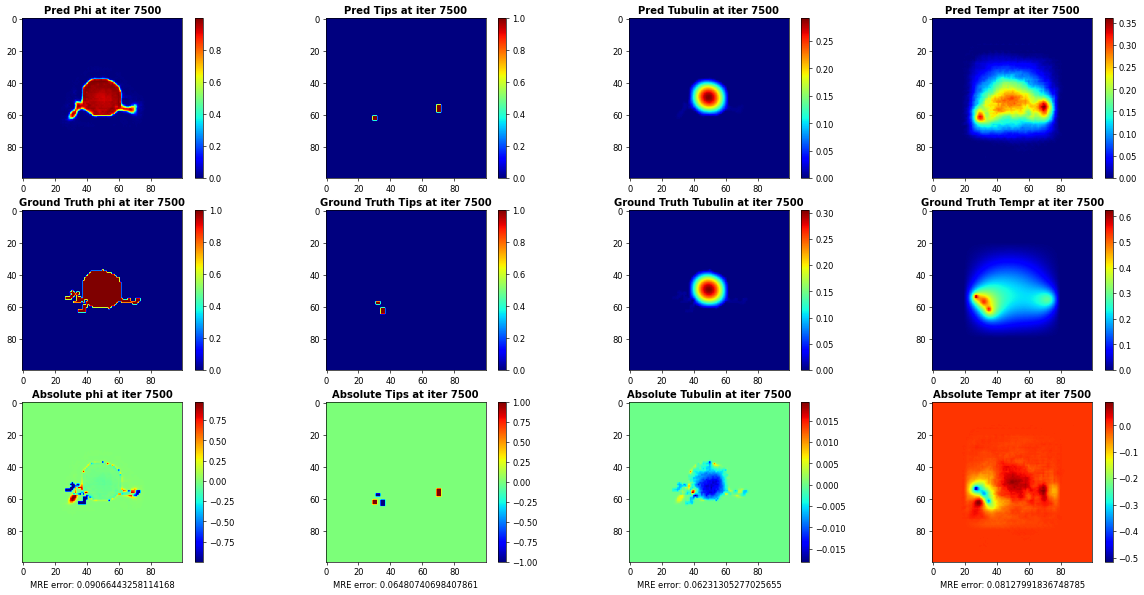

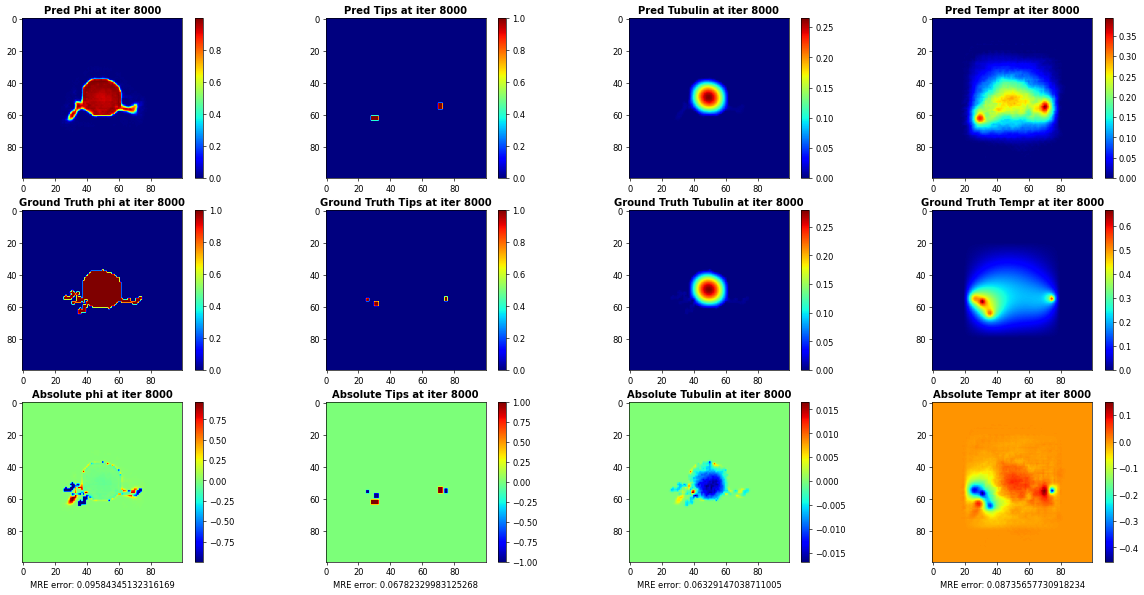

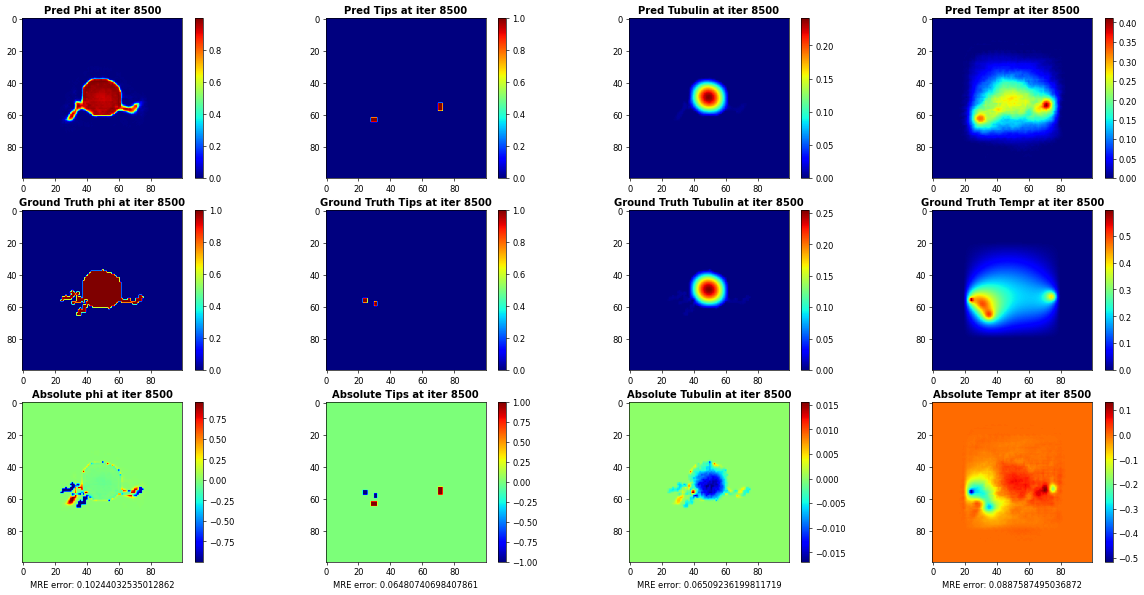

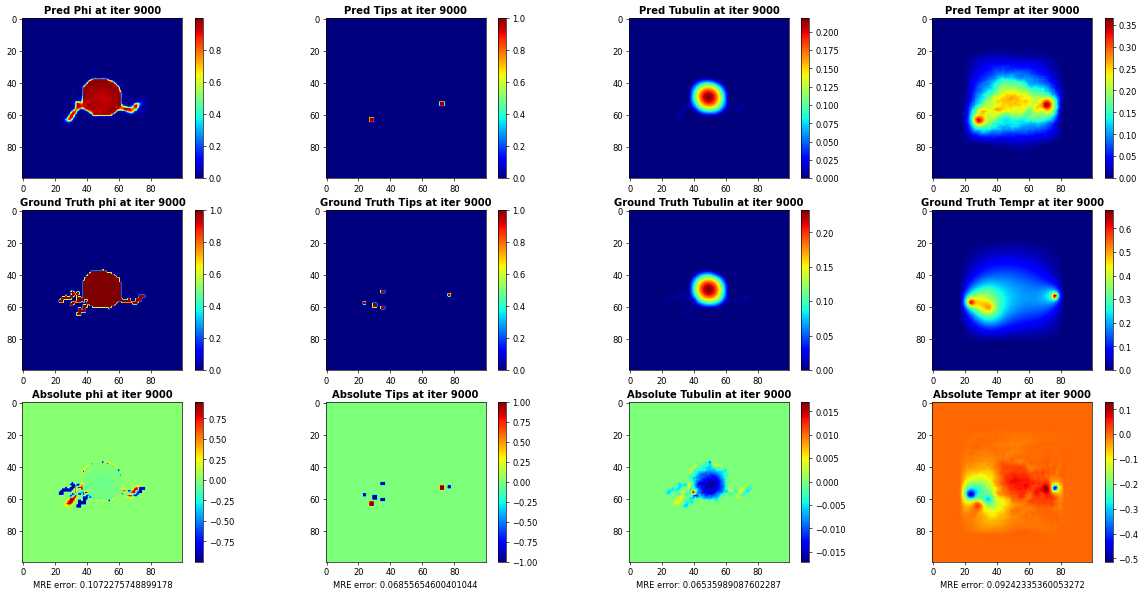

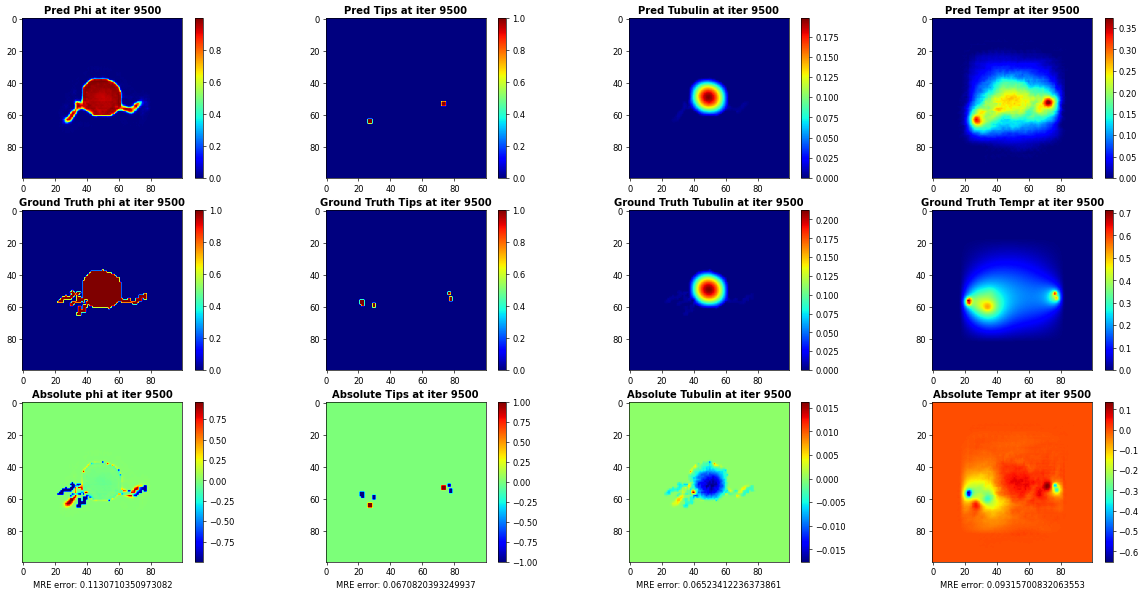

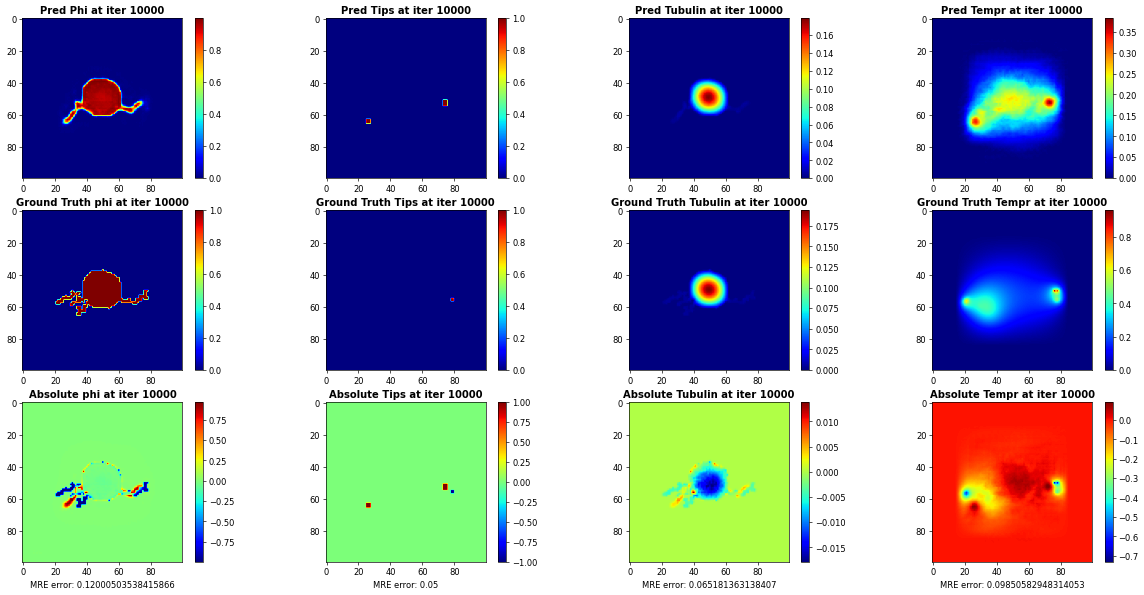

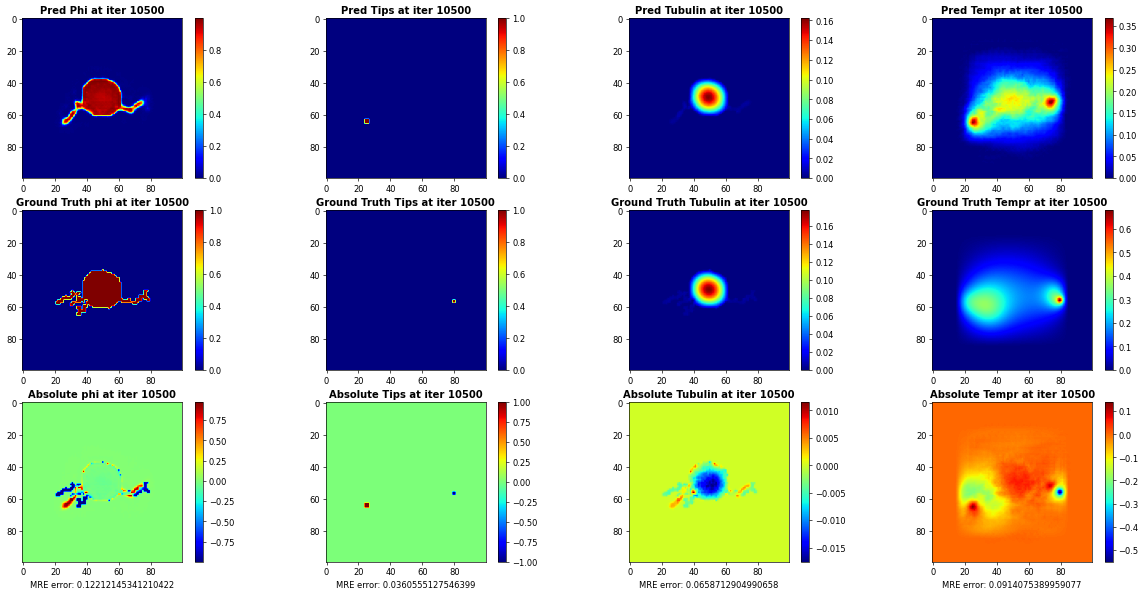

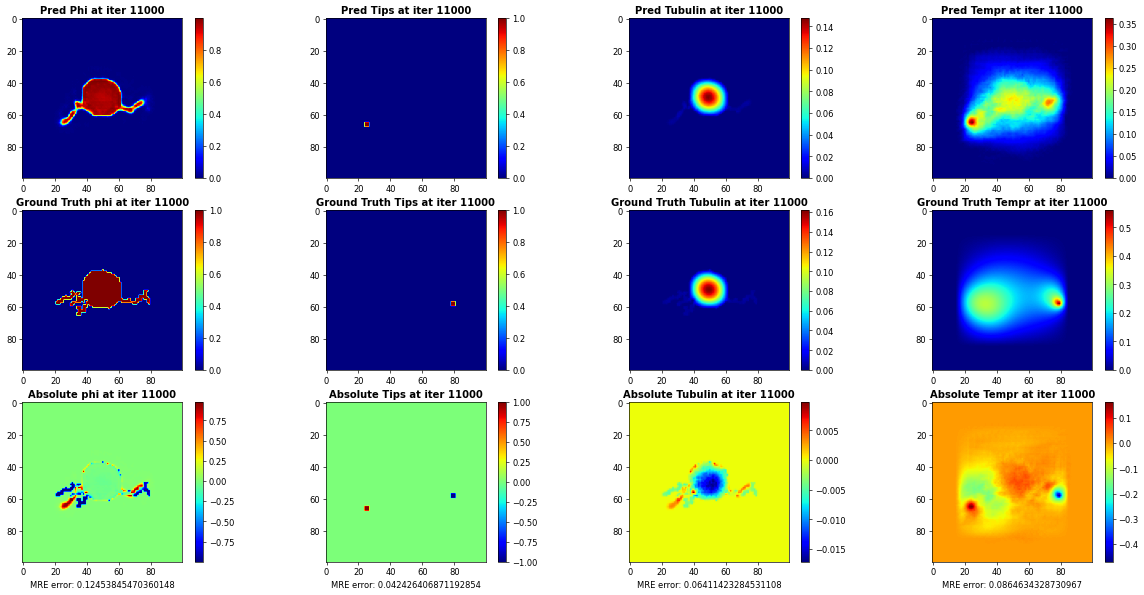

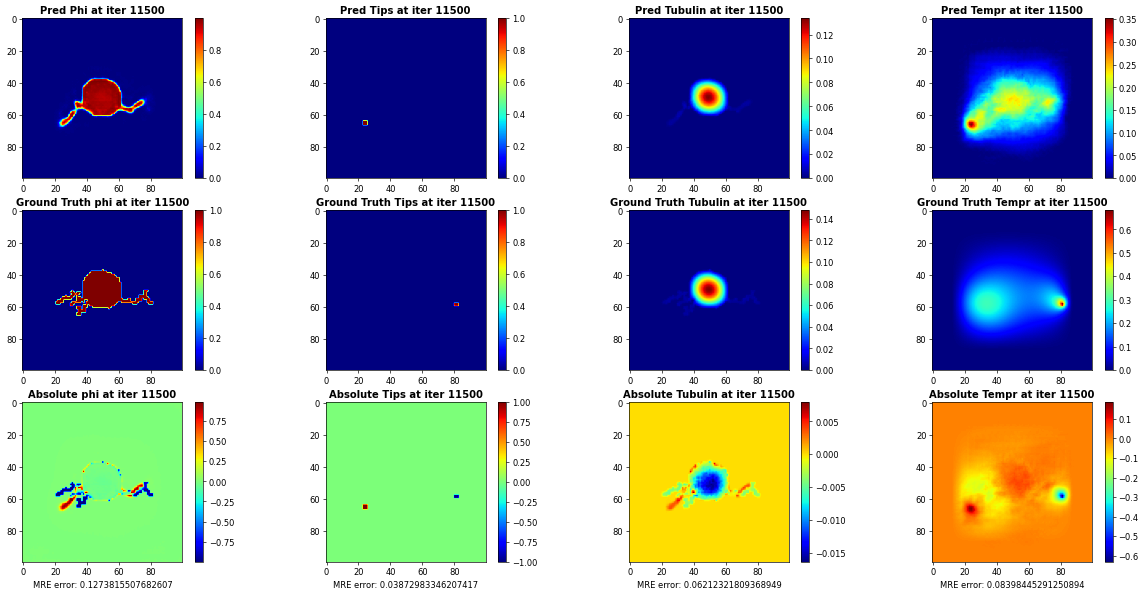

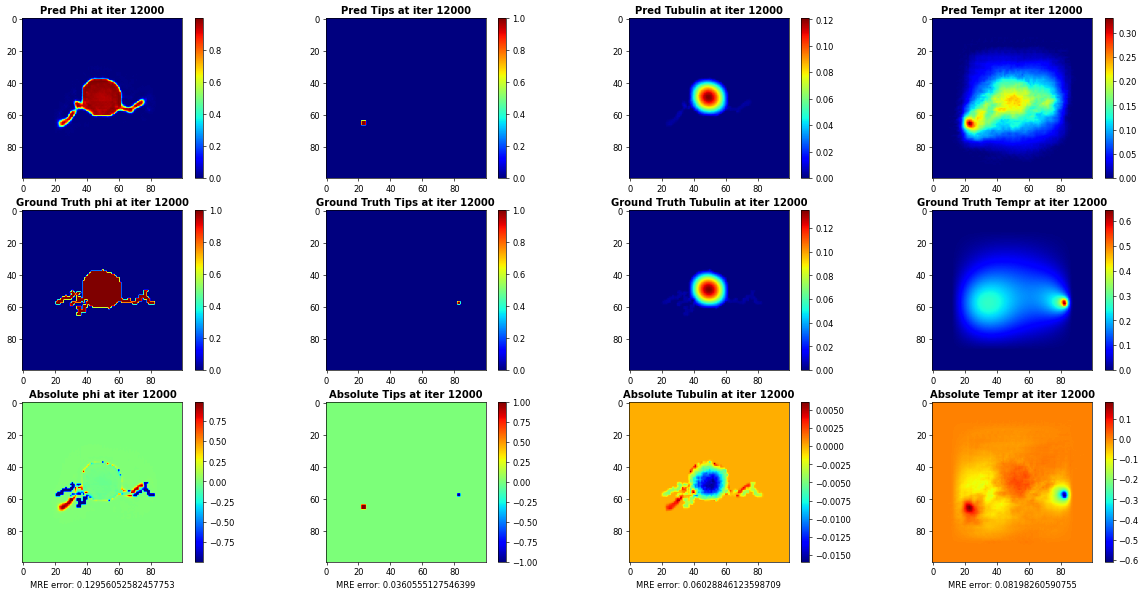

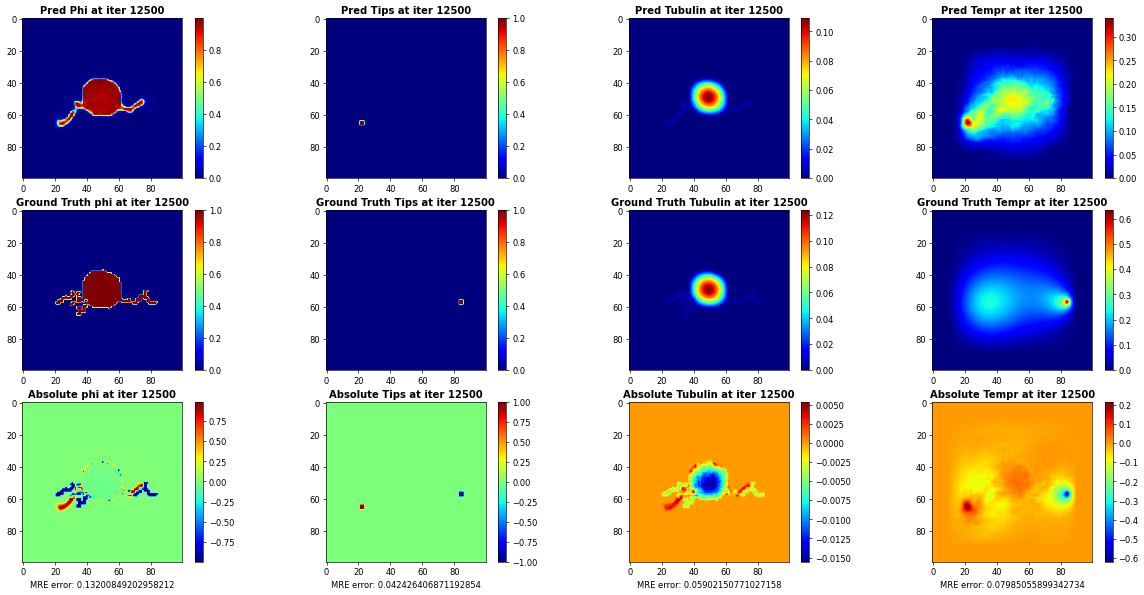

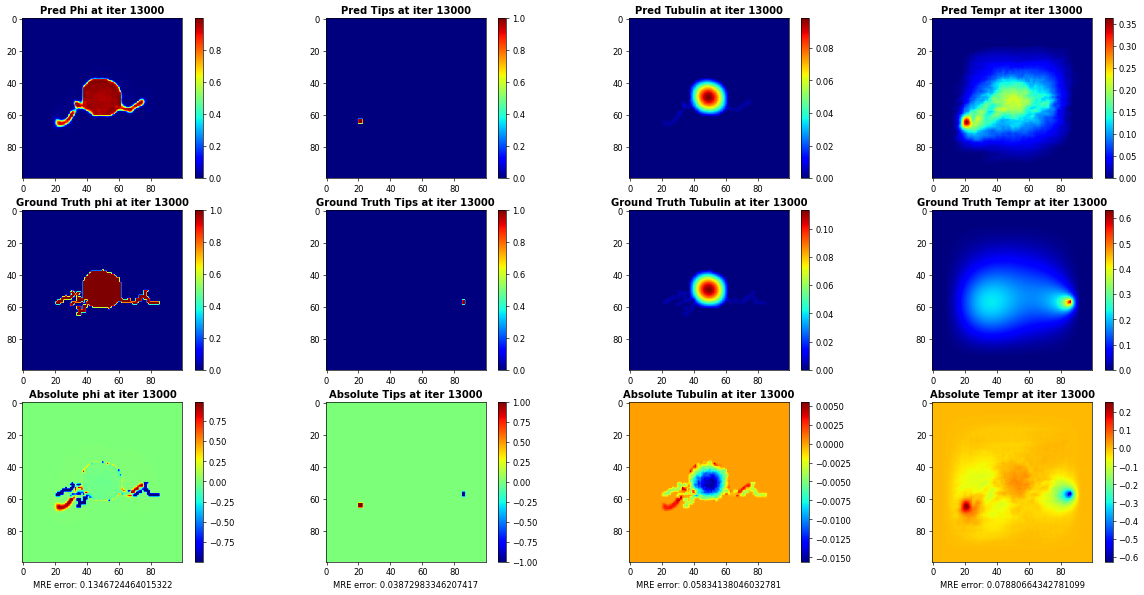

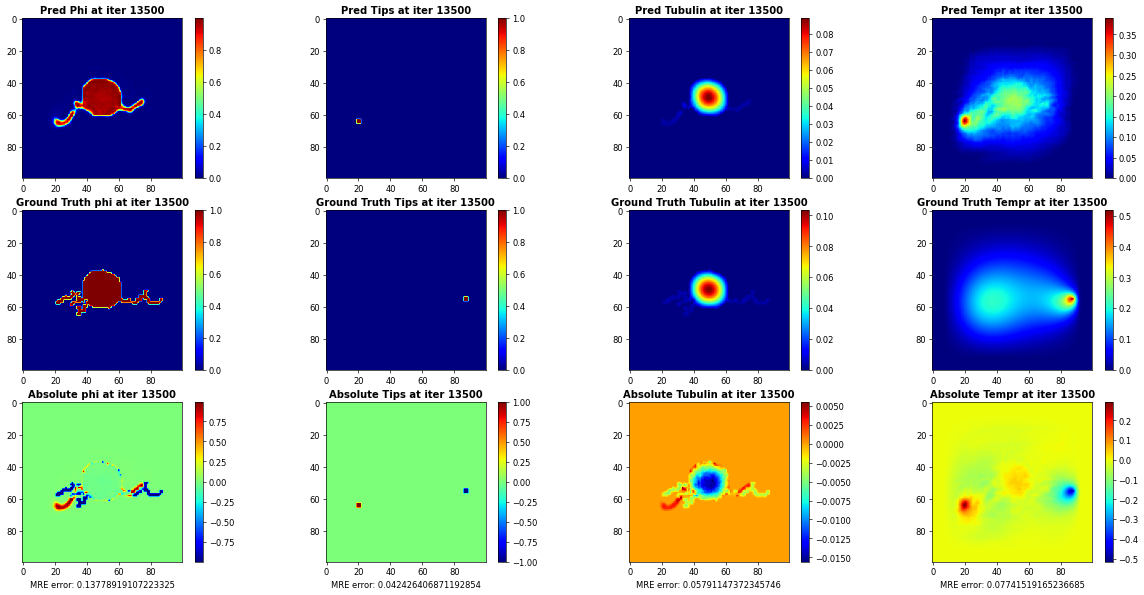

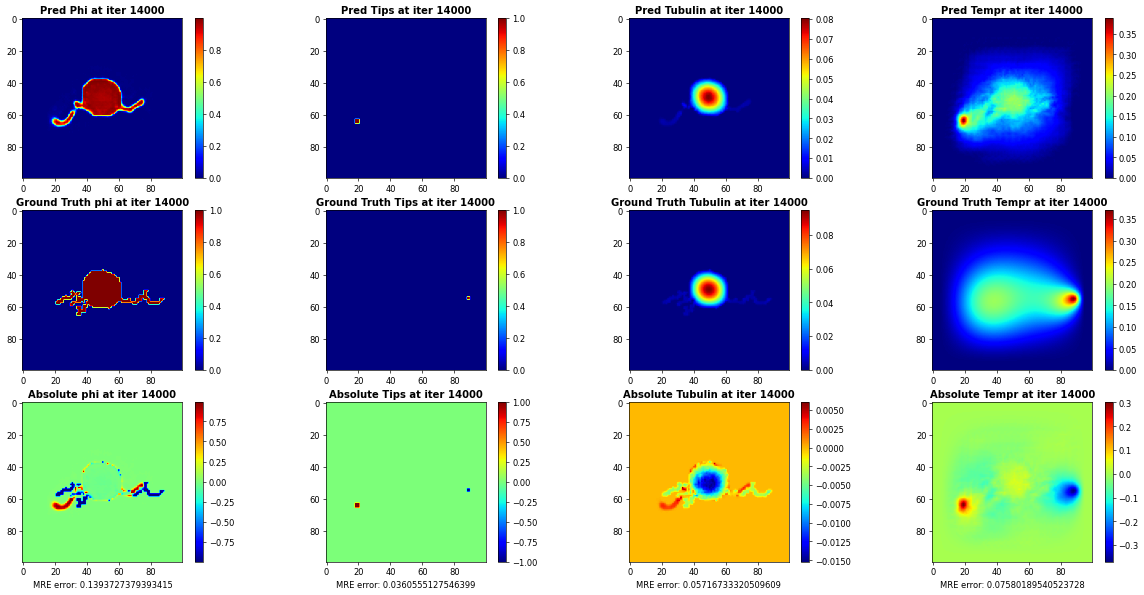

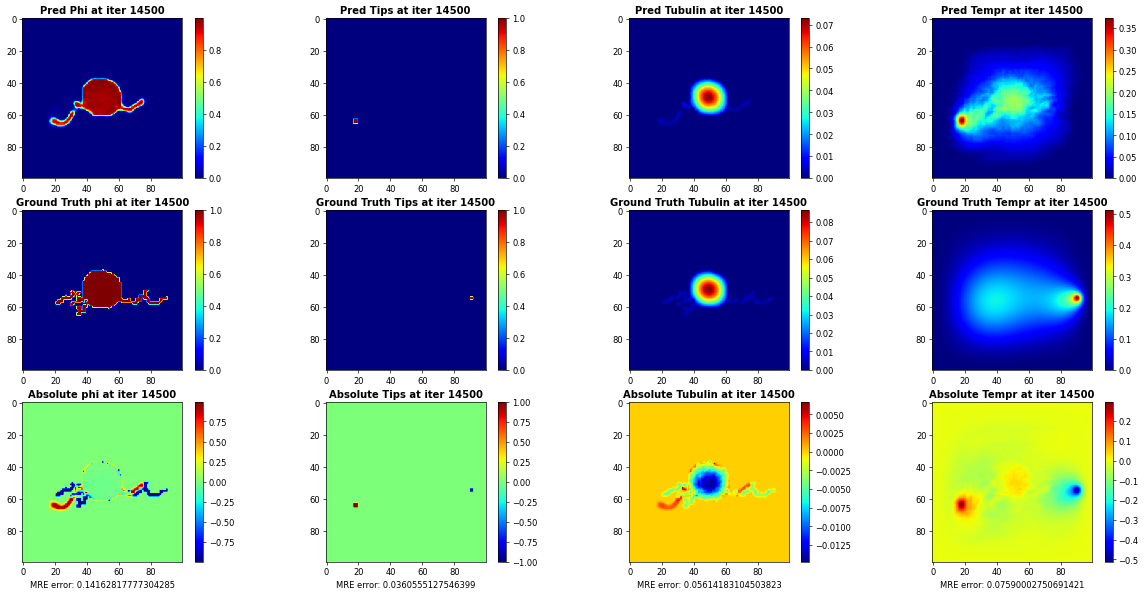

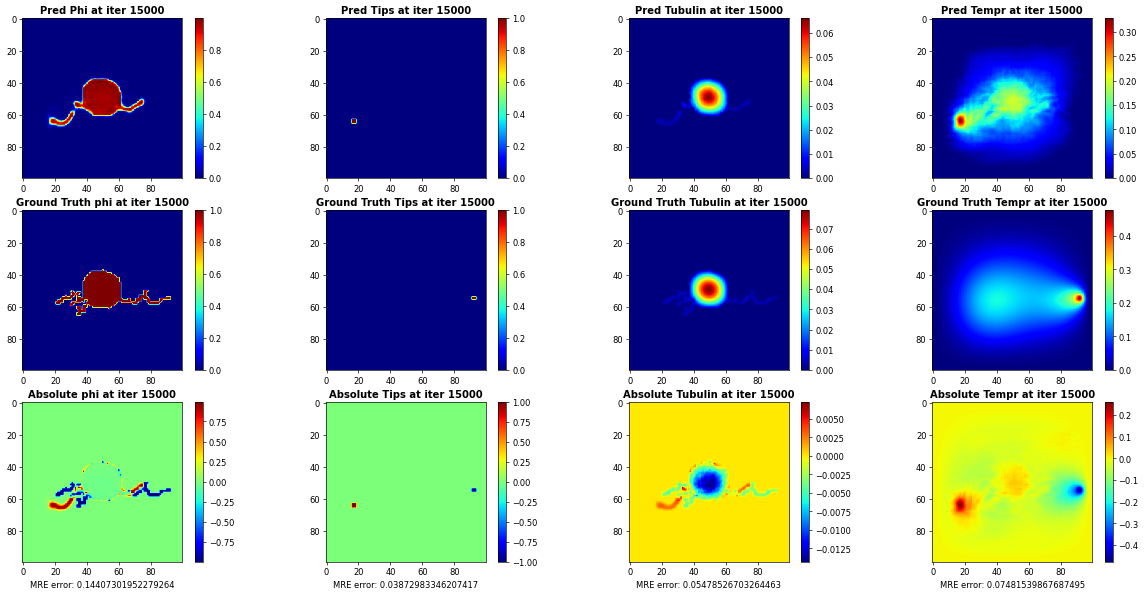

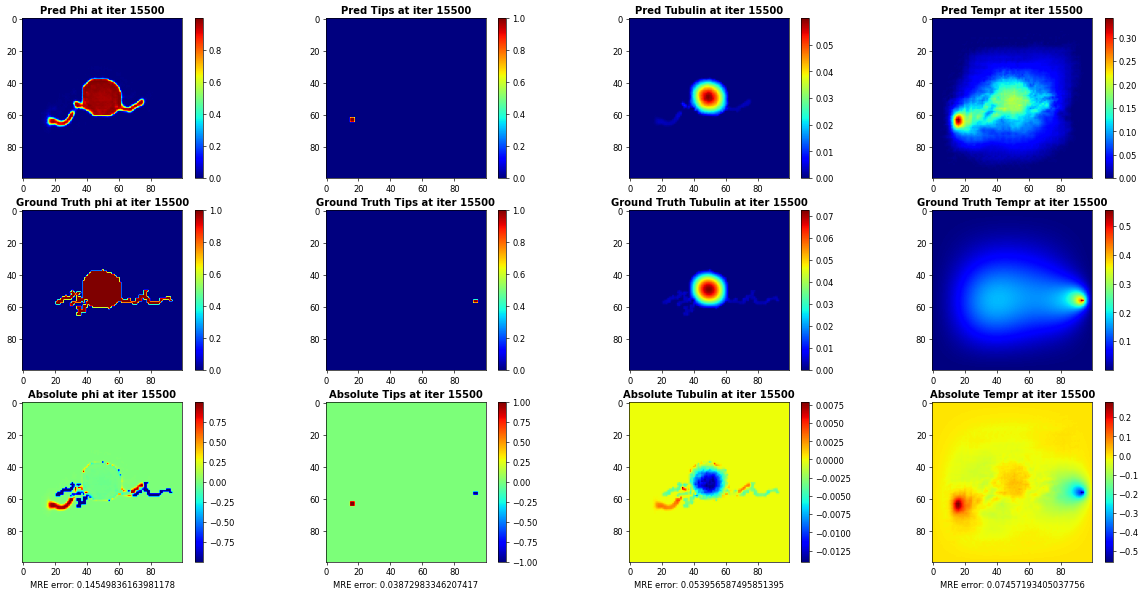

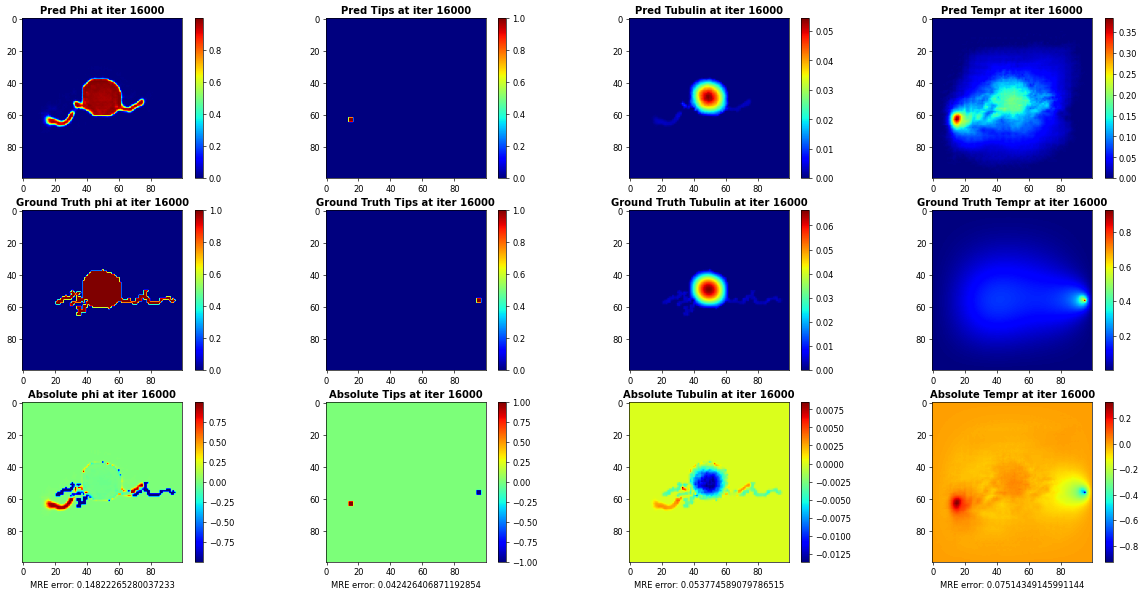

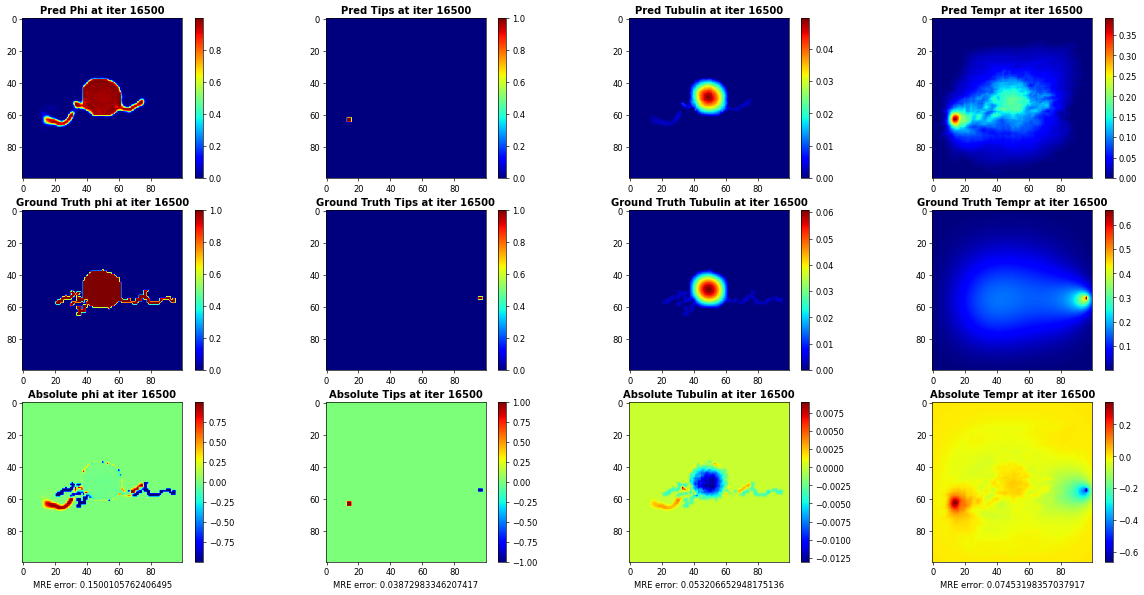

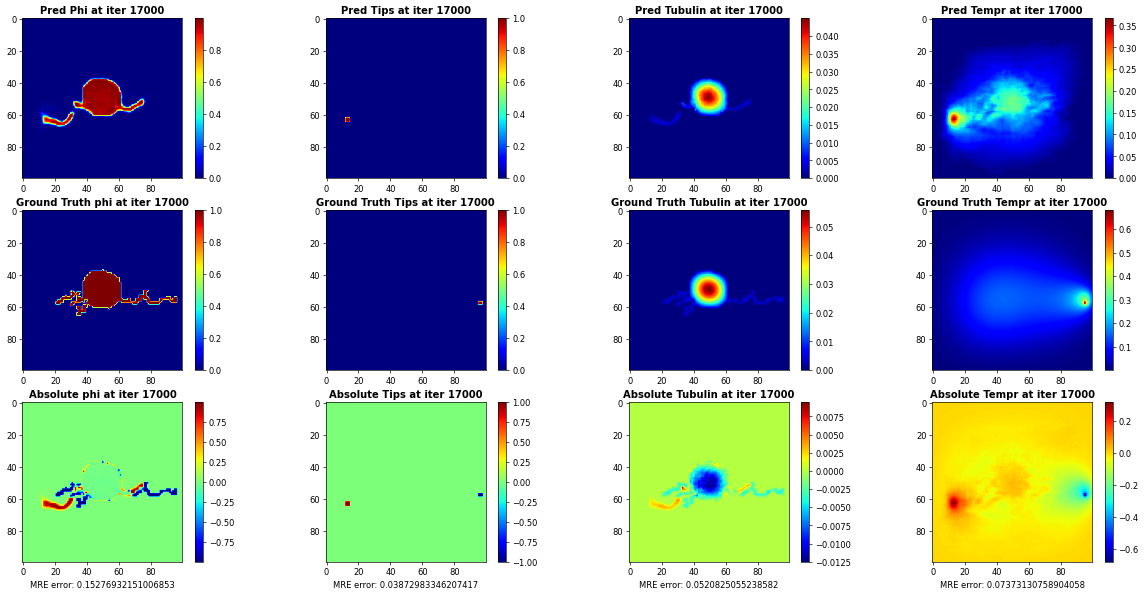

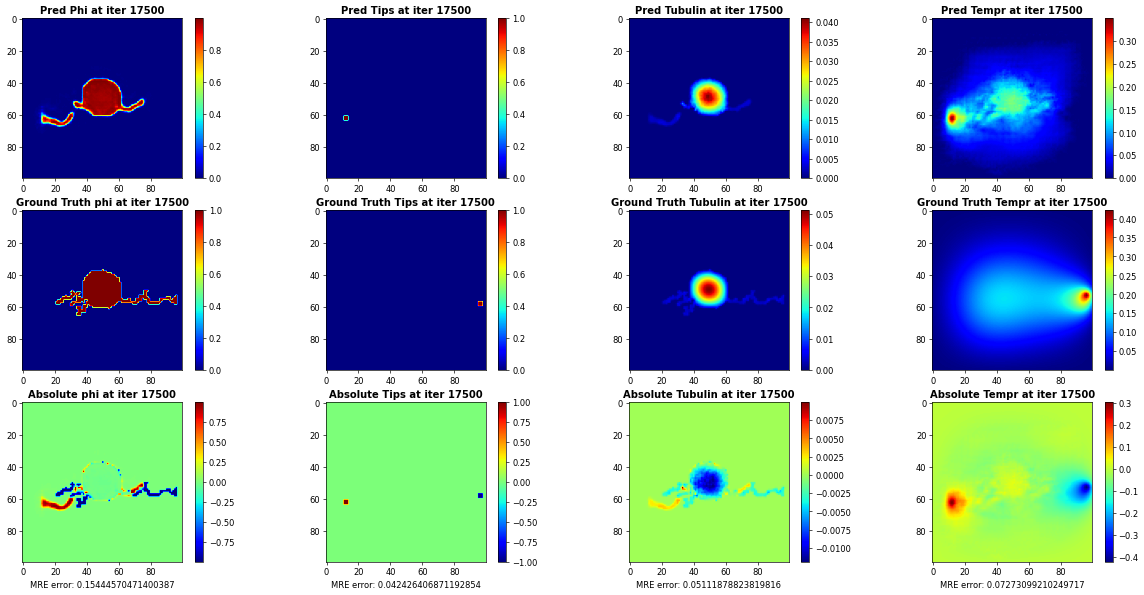

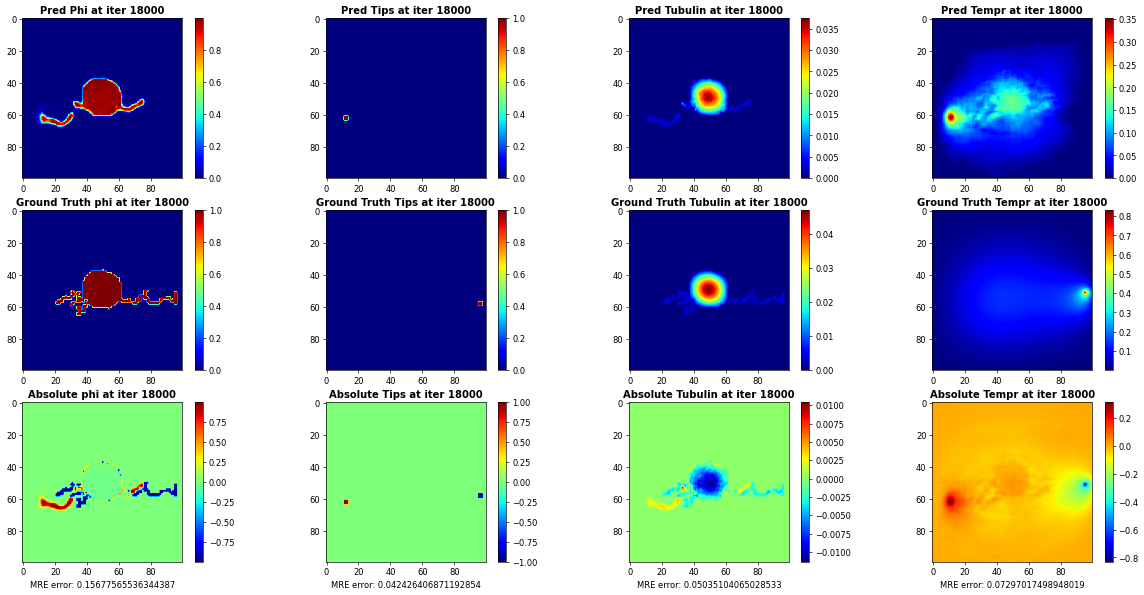

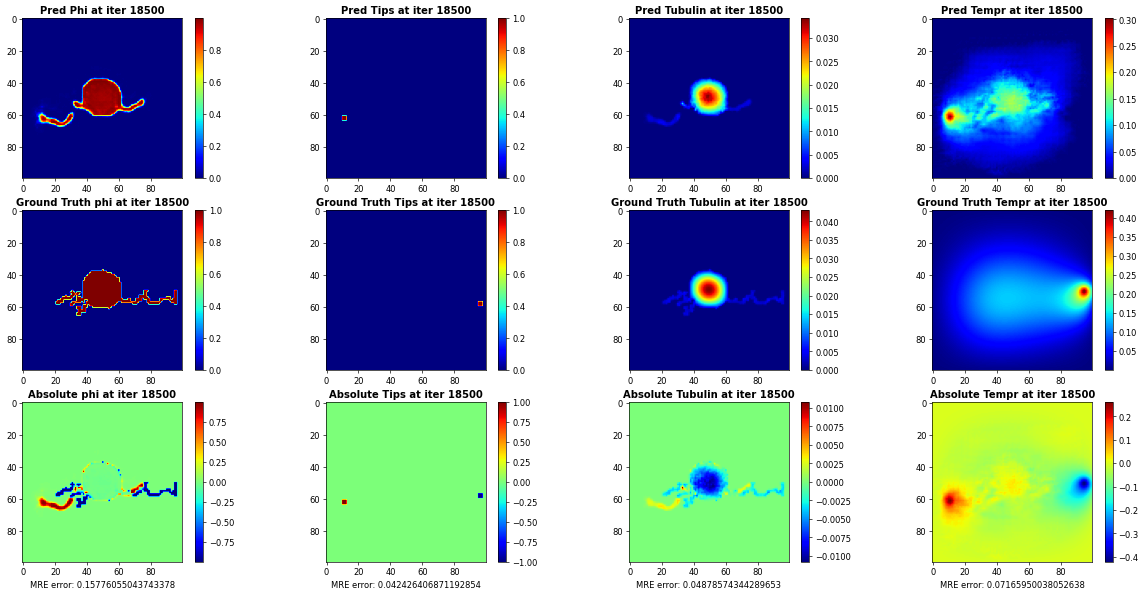

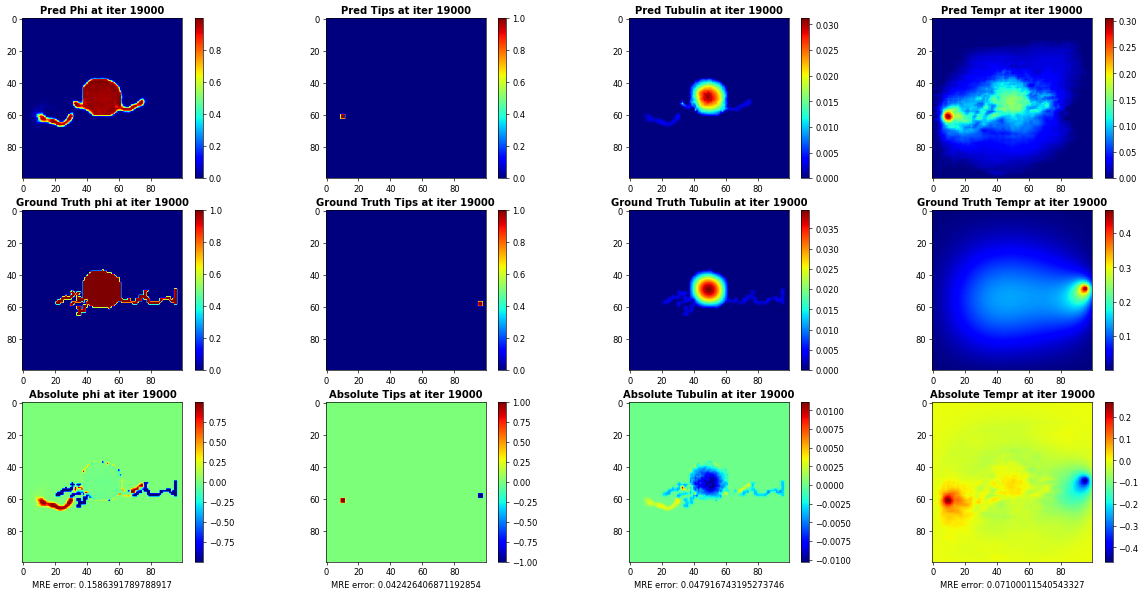

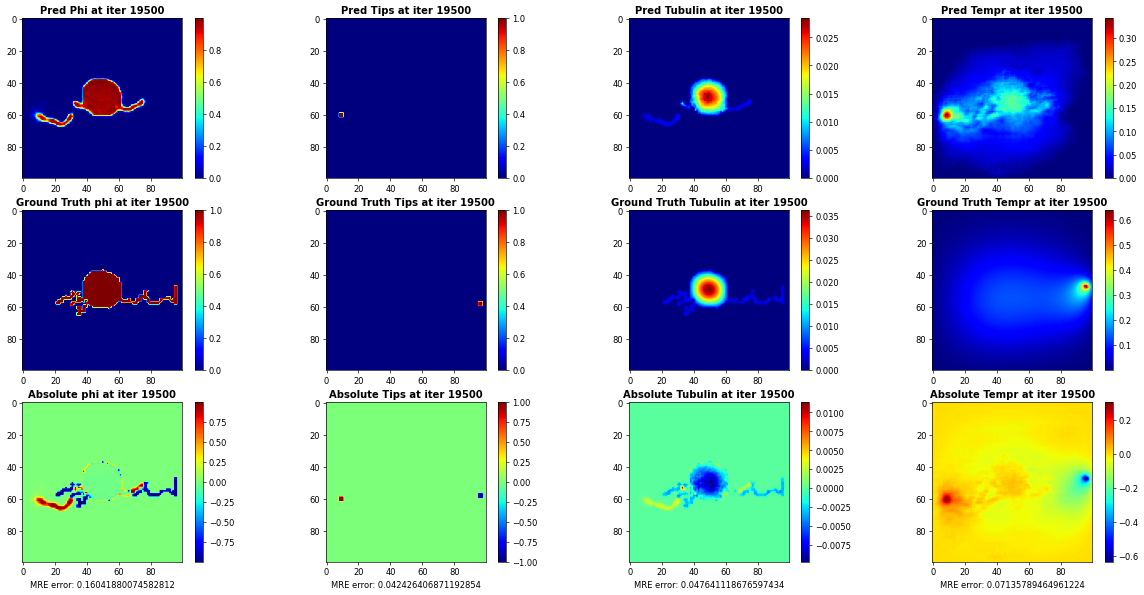

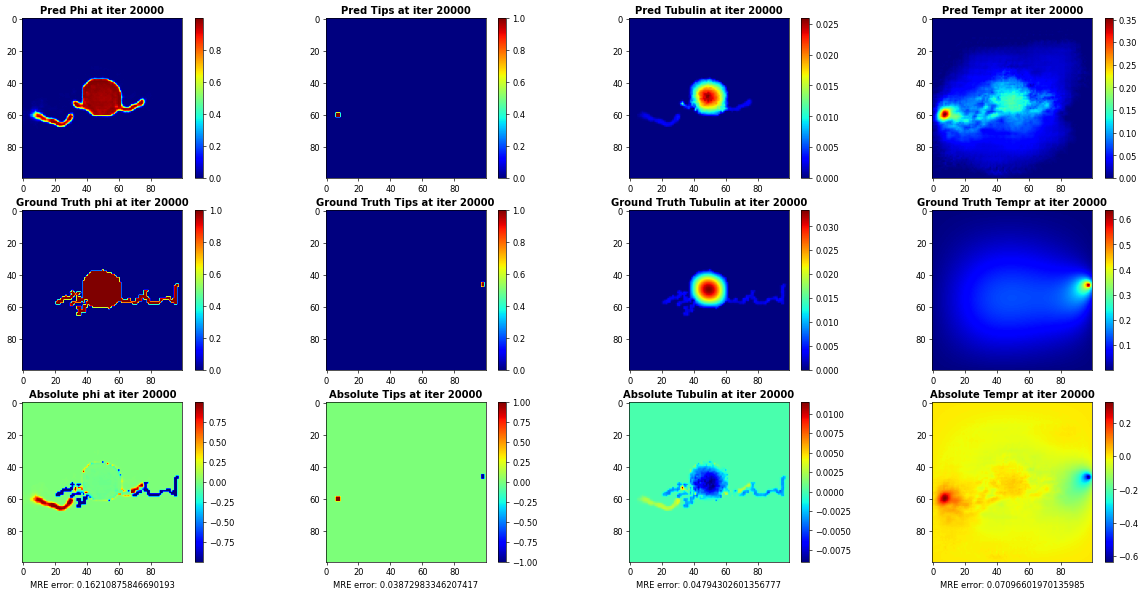

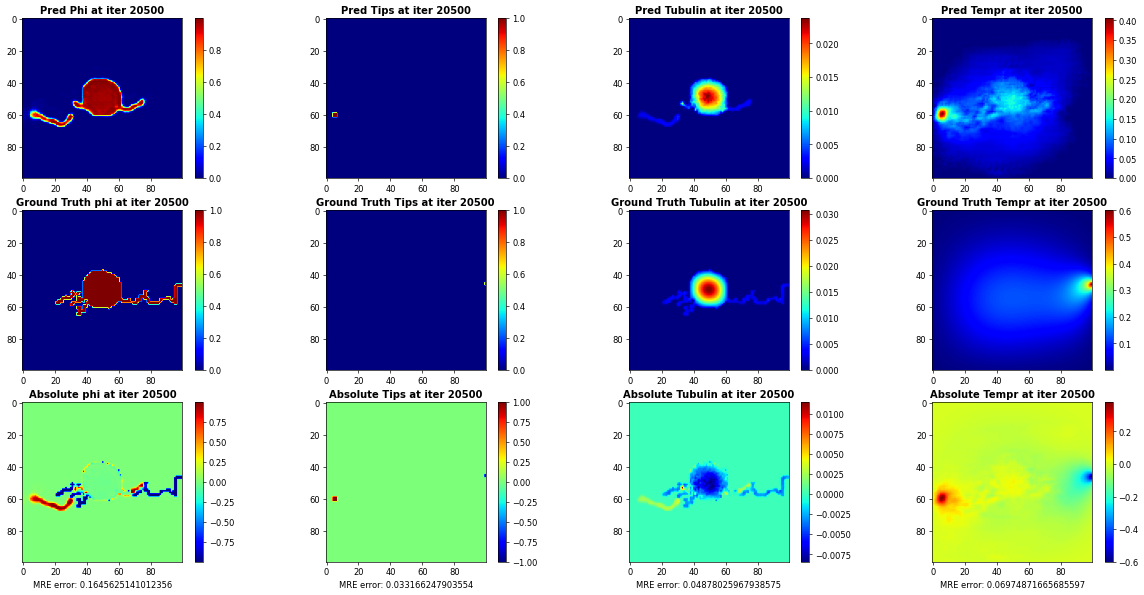

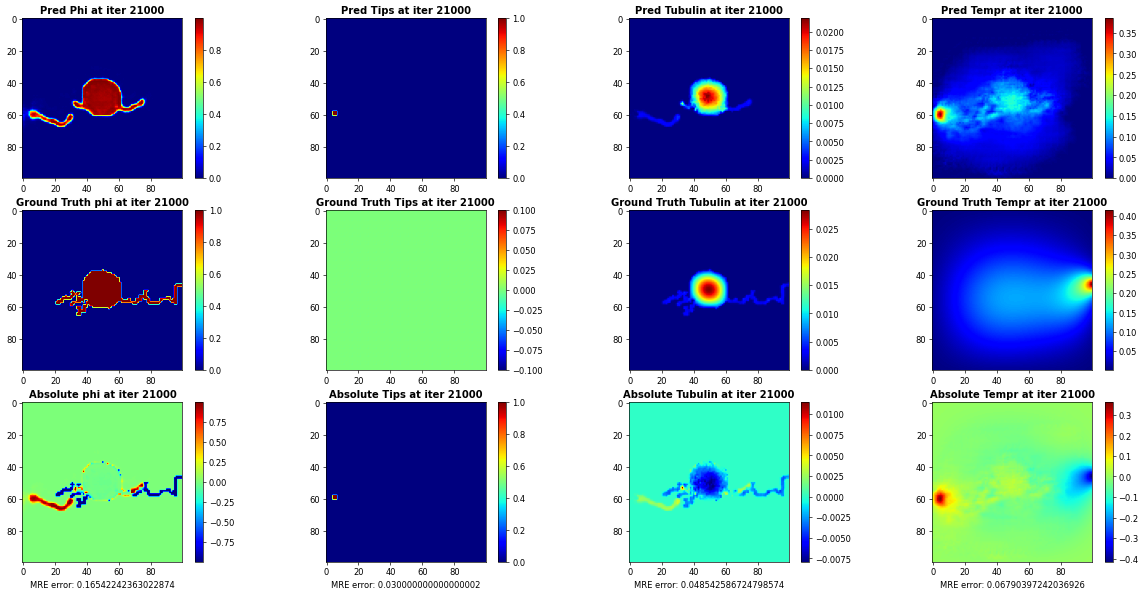

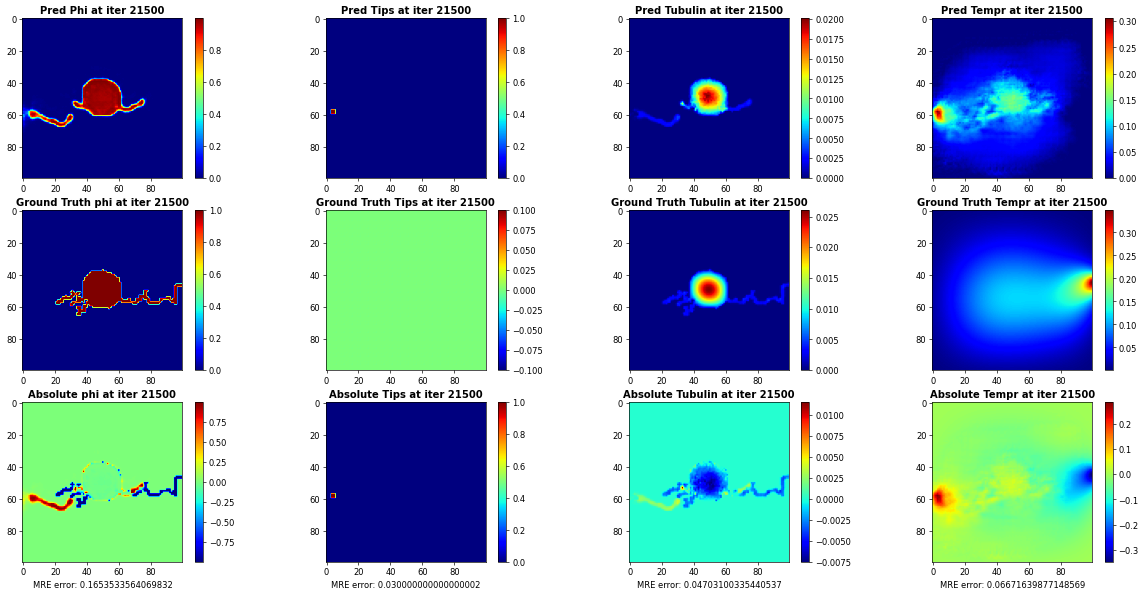

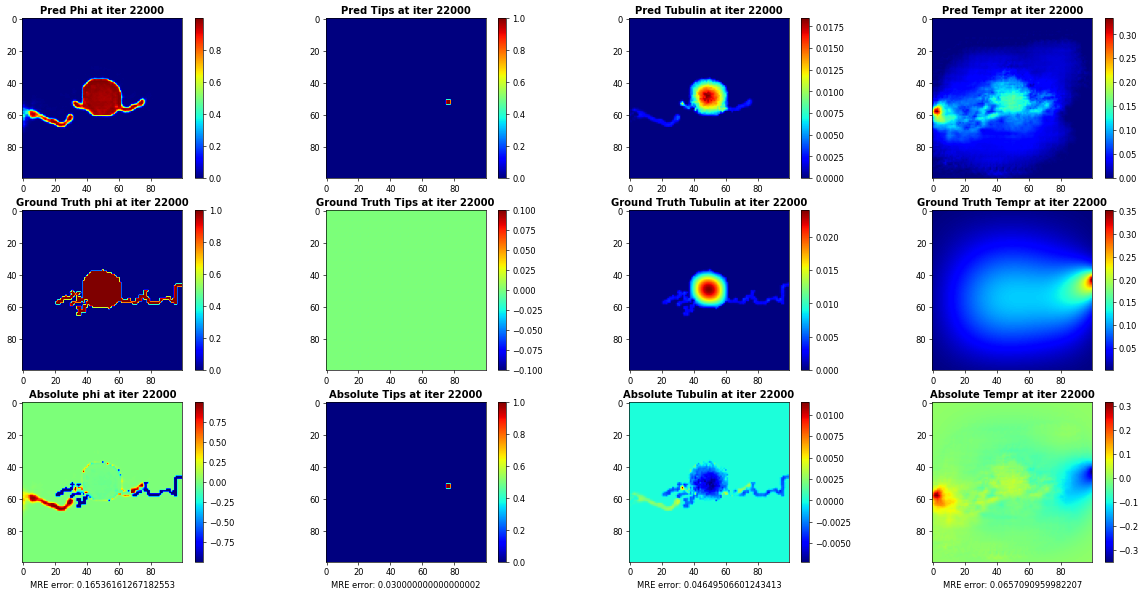

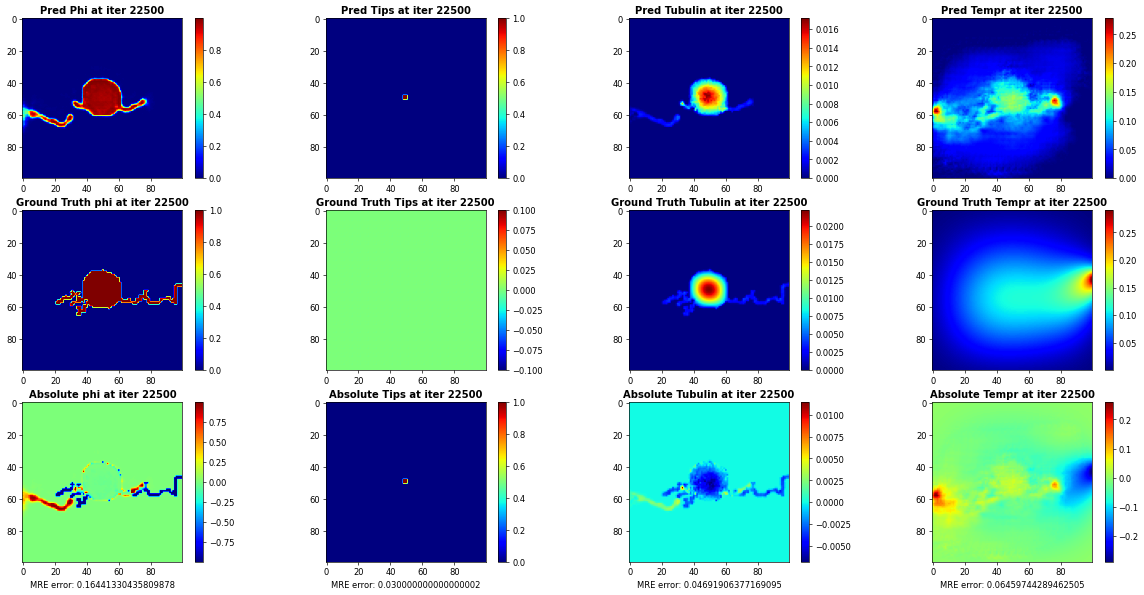

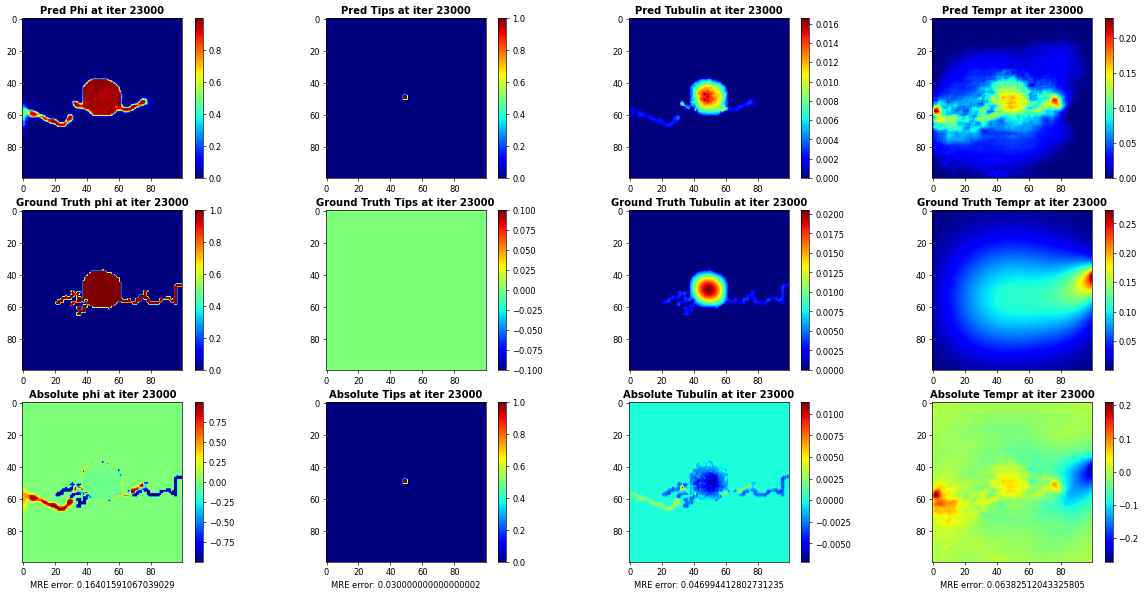

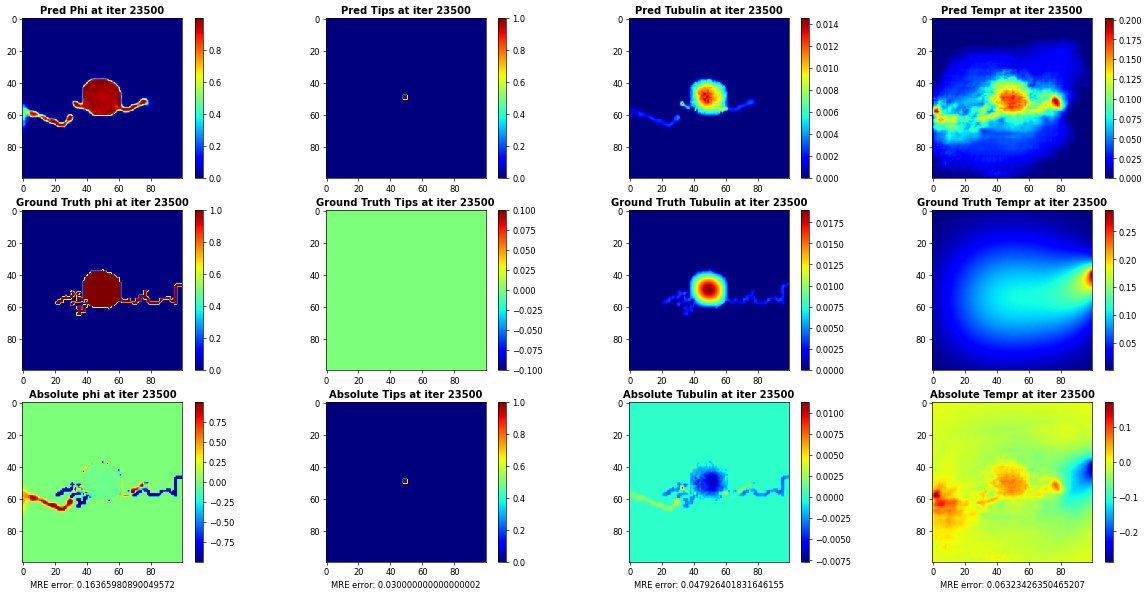

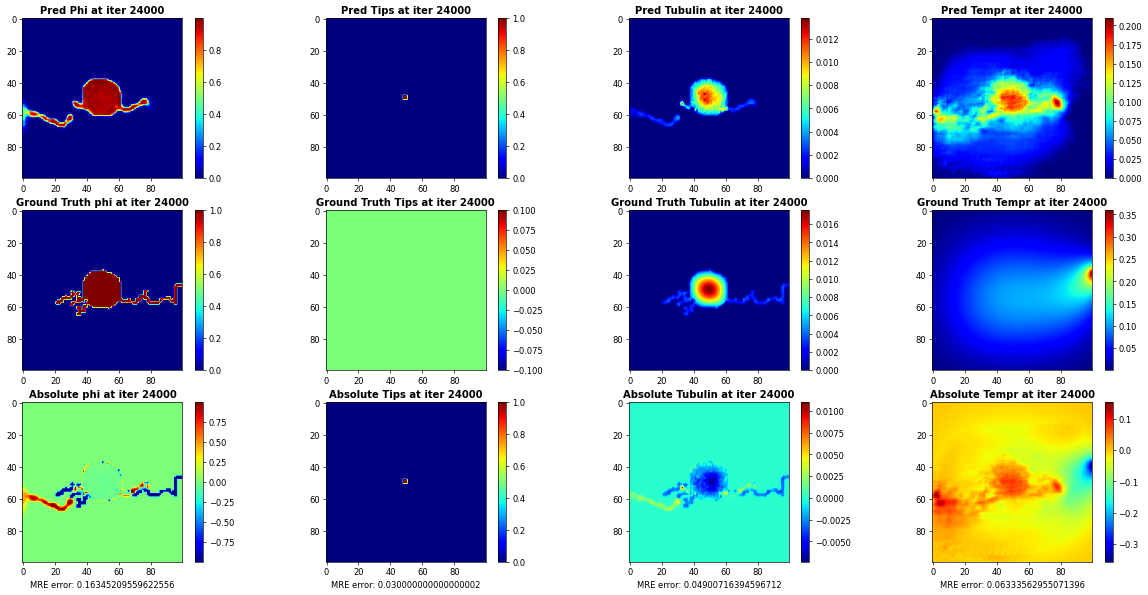

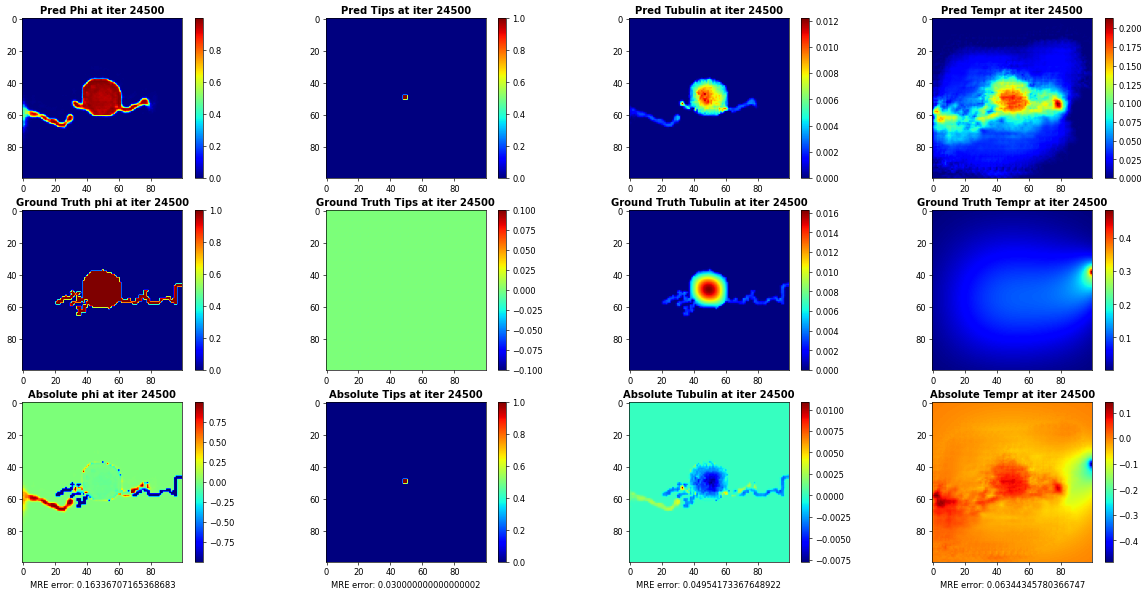

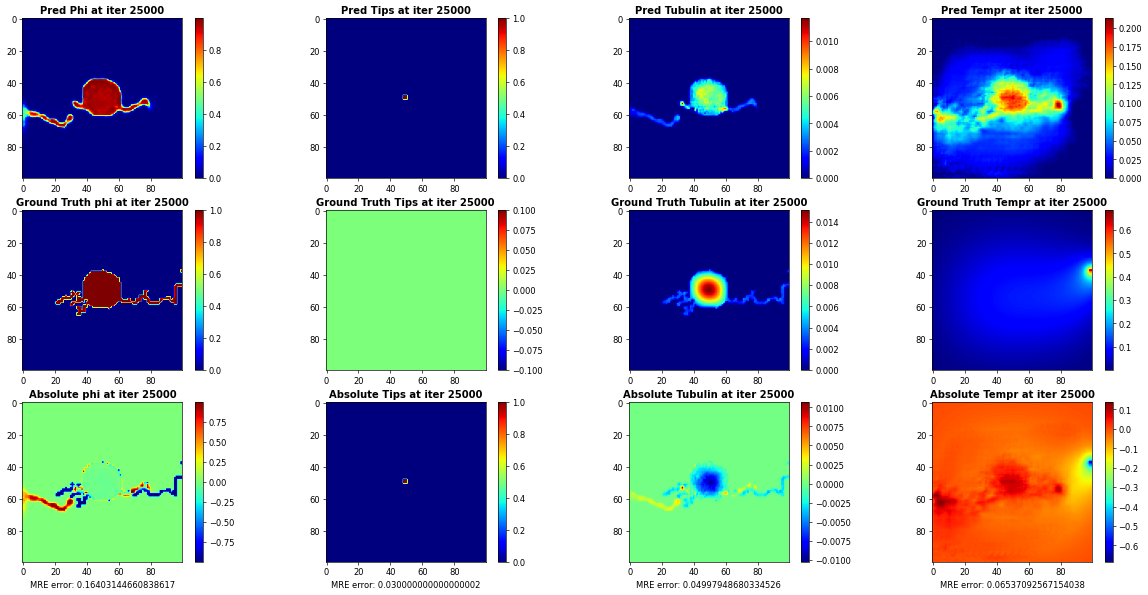

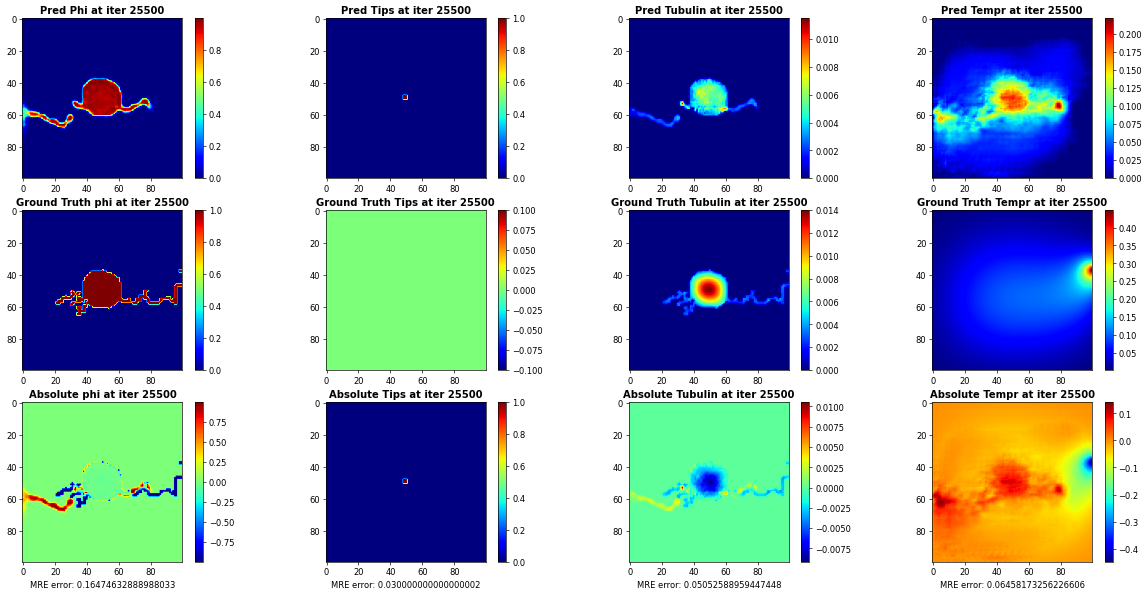

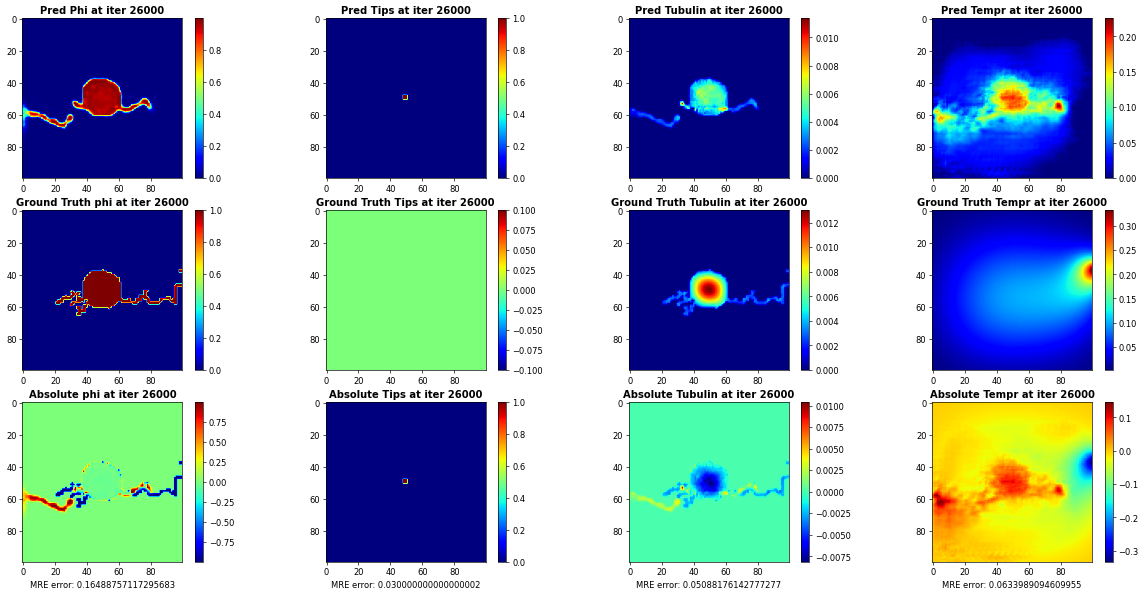

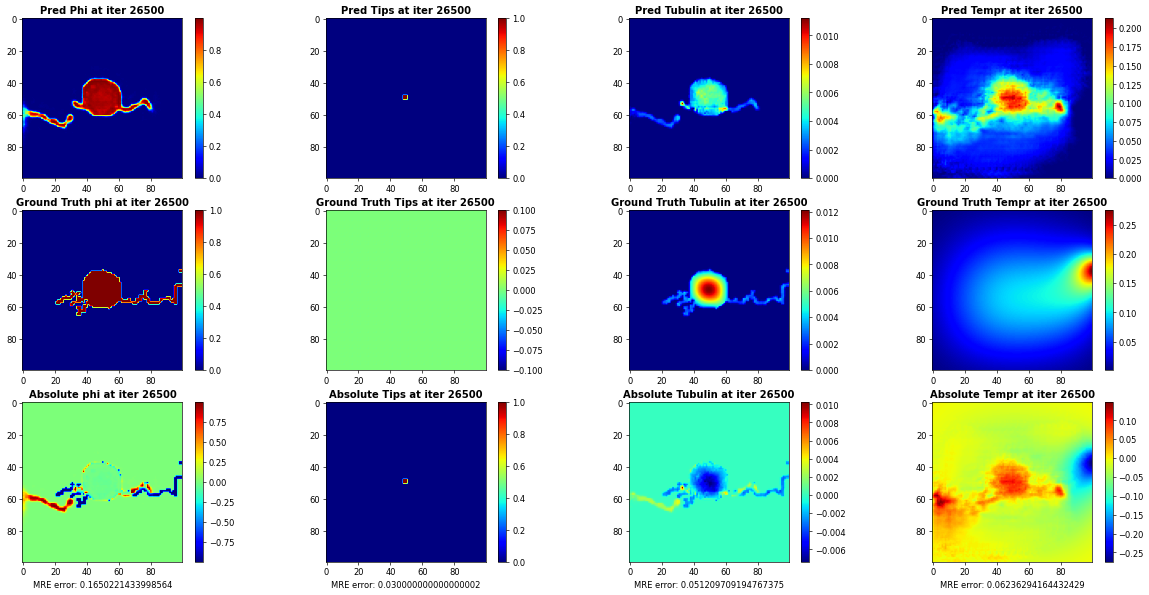

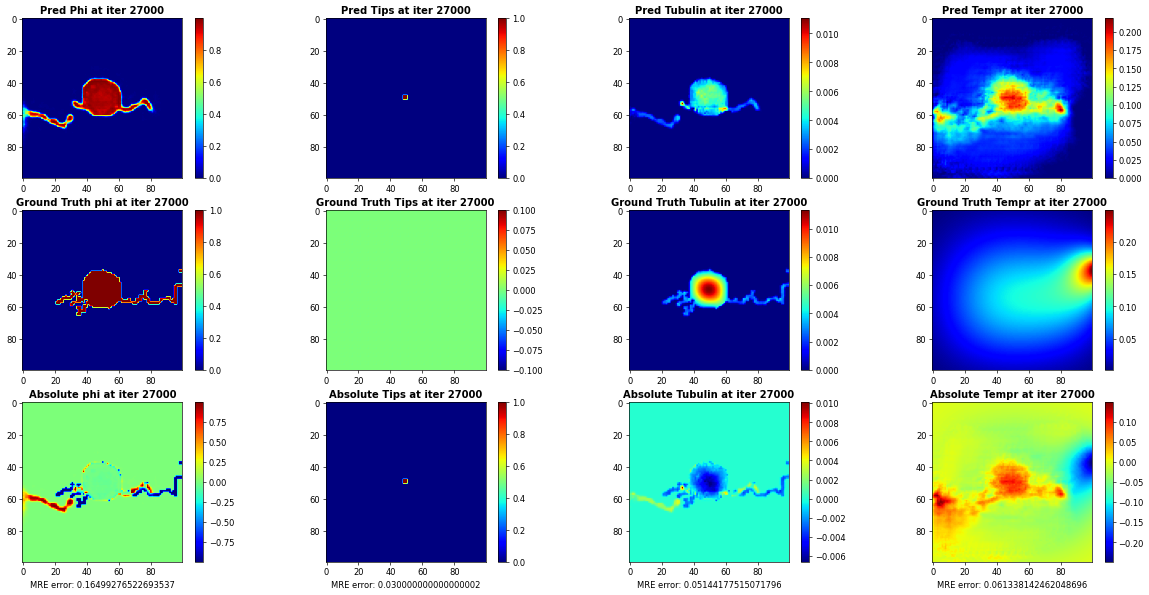

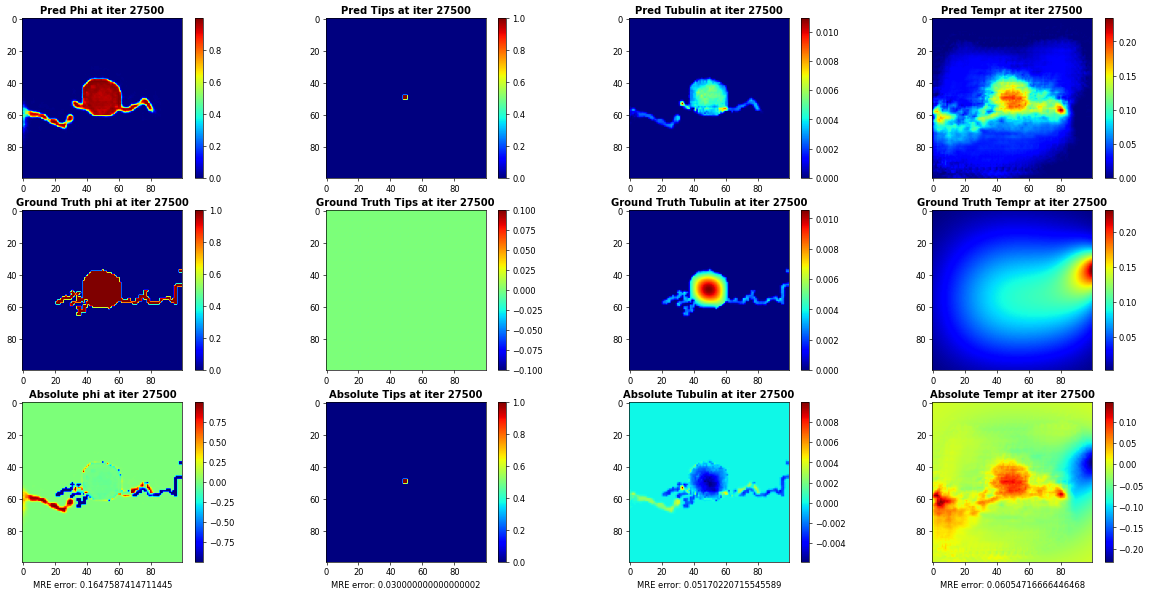

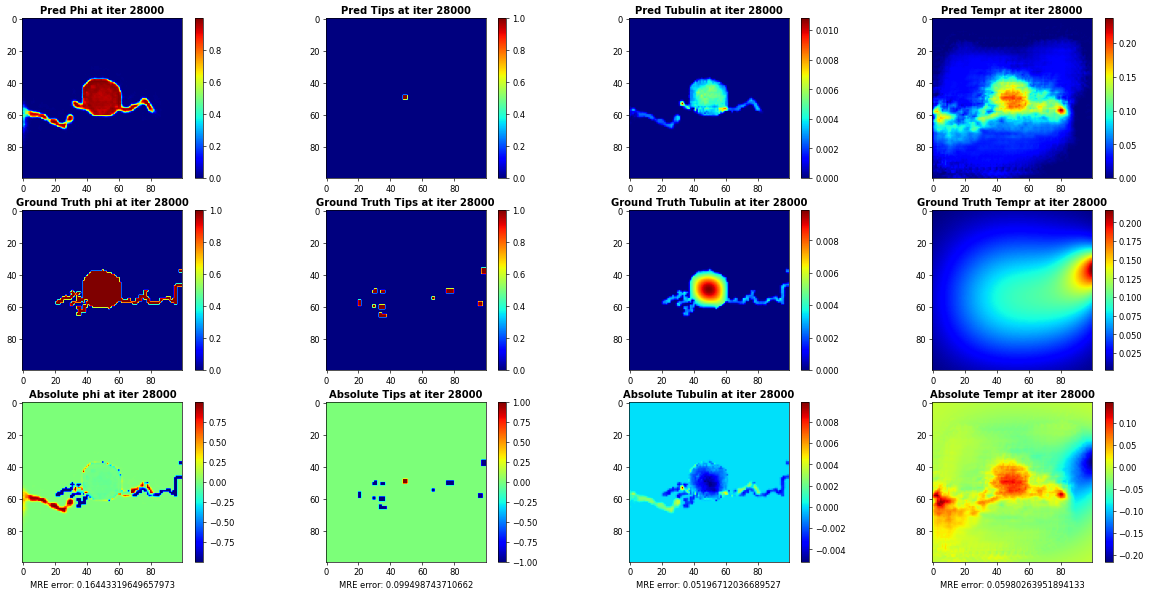

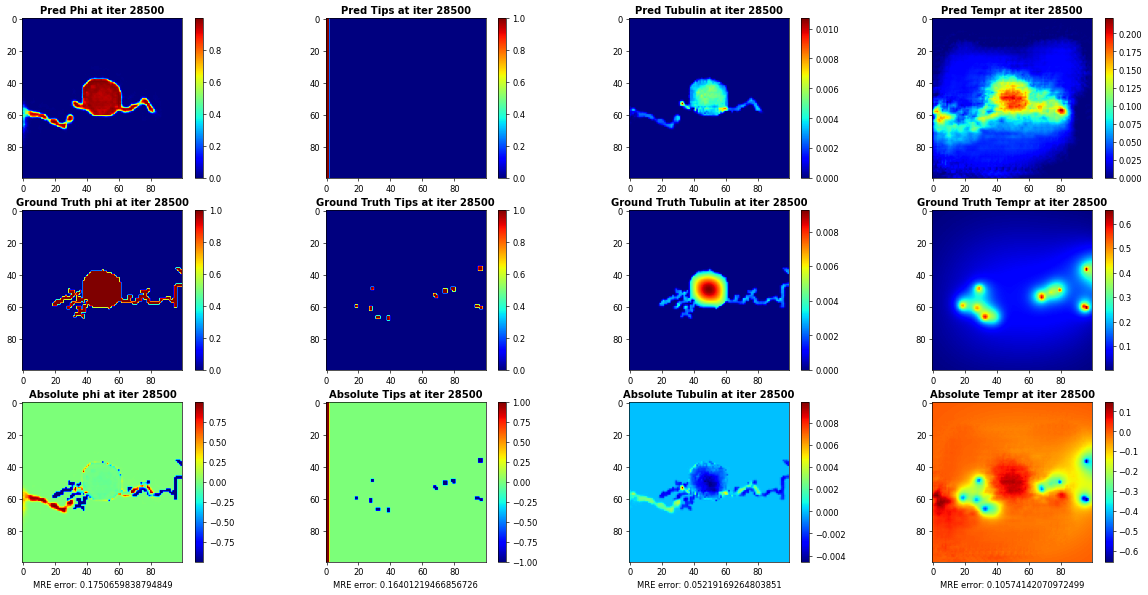

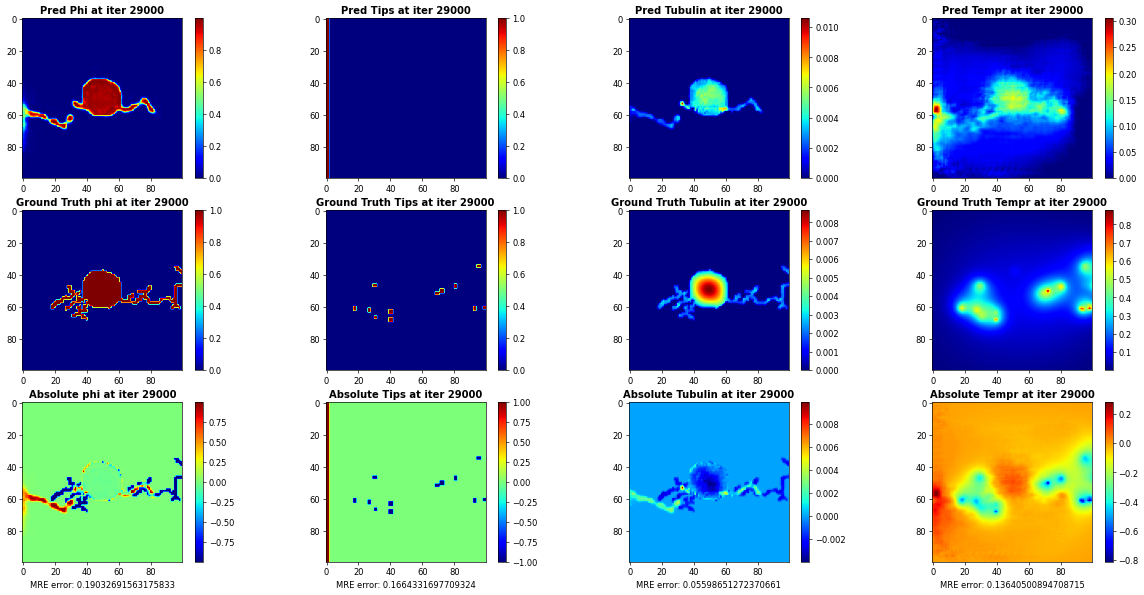

Error in callback <function flush_figures at 0x7f28e4046d30> (for post_execute):


KeyboardInterrupt: 

In [16]:
import copy
# start matlab engine, requires valid installation of matlab and matlab.engine library
import matlab.engine
eng = matlab.engine.start_matlab()
s = eng.genpath('Matlab_algorithm/prev')
eng.addpath(s, nargout=0)

# calc mre between pred and goal
def get_mre(pred,goal):
    return np.sqrt(np.sum(np.square(pred-goal)/(pred.shape[0]*pred.shape[1])))

def push(input, cutoff):
    output = np.zeros(input.shape)
    output[input>(cutoff)] = 1
    return output

# generating intial 5 frame input for predictions
rand_case = np.random.randint((len(val_dataset)))
print(f"Random case: {rand_case}")
example_x = val_dataset[rand_case,:,:,:,0:5]
x_in = np.expand_dims(example_x[0:numFrames,...],axis=0)

from tqdm import tqdm
# loop to continuously make prediction (based on lastest 5 frames)
for i in tqdm(range(64), desc="Plotting and Saving figures ..."):
    iter = (i+1)*500+2500
    # prediction
    new_prediction = model.predict(x_in,verbose="0")
    # phi = push(new_prediction[0,0,:,:,0],0.2)
    # phi = np.round(new_prediction[0,0,:,:,0])
    phi = new_prediction[0,0,:,:,0]
    tips = np.round(eng.generate_tips_for_python(matlab.double(np.array(phi).astype('float64')),iter)) # calc tips using matlab algorithm
    # tips = example_x[i+5,:,:,1]
    # tips = new_prediction[0,0,:,:,1]
    tub = new_prediction[0,0,:,:,2]
    tempr = new_prediction[0,0,:,:,3]
    theta = new_prediction[0,0,:,:,4]

    # plot prediction
    plt.figure(figsize=(25, 12), dpi=60)
    plt.gcf().set_facecolor("white")
    plt.subplot(3,4,1)
    plt.imshow(phi, cmap='jet')
    plt.colorbar()
    plt.title(f"Pred Phi at iter {iter}", fontweight='bold')
    plt.subplot(3,4,2)
    plt.imshow(tips, cmap='jet')
    plt.colorbar()
    plt.title(f"Pred Tips at iter {iter}", fontweight='bold')
    plt.subplot(3,4,3)
    plt.imshow(tub, cmap='jet')
    plt.colorbar()
    plt.title(f"Pred Tubulin at iter {iter}", fontweight='bold')
    plt.subplot(3,4,4)
    plt.imshow(tempr, cmap='jet')
    plt.colorbar()
    plt.title(f"Pred Tempr at iter {iter}", fontweight='bold')
    # plot ground truth
    plt.subplot(3,4,5)
    plt.imshow(example_x[i+5,:,:,0], cmap='jet')
    plt.colorbar()
    plt.title(f"Ground Truth phi at iter {iter}", fontweight='bold')
    plt.subplot(3,4,6)
    plt.imshow(example_x[i+5,:,:,1], cmap='jet')
    plt.colorbar()
    plt.title(f"Ground Truth Tips at iter {iter}", fontweight='bold')
    plt.subplot(3,4,7)
    plt.imshow(example_x[i+5,:,:,2], cmap='jet')
    plt.colorbar()
    plt.title(f"Ground Truth Tubulin at iter {iter}", fontweight='bold')
    plt.subplot(3,4,8)
    plt.imshow(example_x[i+5,:,:,3], cmap='jet')
    plt.colorbar()
    plt.title(f"Ground Truth Tempr at iter {iter}", fontweight='bold')
    # calc mean relative error
    mre_phi = get_mre(phi,example_x[i+5,:,:,0])
    mre_tips = get_mre(tips,example_x[i+5,:,:,1])
    mre_tempr = get_mre(tempr,example_x[i+5,:,:,2])
    mre_tub = get_mre(tub,example_x[i+5,:,:,3])
    mre_theta = get_mre(theta,example_x[i+5,:,:,4])
    # plot error
    plt.subplot(3,4,9)
    plt.imshow(phi-example_x[i+5,:,:,0], cmap='jet')
    plt.colorbar()
    plt.title(f"Absolute phi at iter {iter}", fontweight='bold')
    plt.xlabel(f"MRE error: {mre_phi}")
    plt.subplot(3,4,10)
    plt.imshow(tips-example_x[i+5,:,:,1], cmap='jet')
    plt.colorbar()
    plt.title(f"Absolute Tips at iter {iter}", fontweight='bold')
    plt.xlabel(f"MRE error: {mre_tips}")
    plt.subplot(3,4,11)
    plt.imshow(tub-example_x[i+5,:,:,2], cmap='jet')
    plt.colorbar()
    plt.title(f"Absolute Tubulin at iter {iter}", fontweight='bold')
    plt.xlabel(f"MRE error: {mre_tempr}")
    plt.subplot(3,4,12)
    plt.imshow(tempr-example_x[i+5,:,:,3], cmap='jet')
    plt.colorbar()
    plt.title(f"Absolute Tempr at iter {iter}", fontweight='bold')
    plt.xlabel(f"MRE error: {mre_tub}")
    # save fig
    # plt.savefig(f"gif/{iter:05d}.png")
    # plt.show()

    # update prediction for later use as input (shifting)
    tmp_var = copy.copy(new_prediction)
    tmp_var[0,-1,:,:,0] = phi
    tmp_var[0,-1,:,:,1] = tips
    tmp = np.zeros(x_in.shape)
    for j in range(numFrames-1):
        tmp[0,j,...] = x_in[0,j+1,...]
    tmp[0,-1,:,:,:] = tmp_var
    x_in = tmp

eng.quit()